# Primary Tasks - Pre-Meeting Analysis

This notebook addresses the following priority tasks:

1. **Iron/EC Ratio - Combined Site Analysis**: All sites combined, colored by iron/EC ratio with threshold testing
2. **HIPS-based Iron Analysis**: Repeat iron analysis using HIPS instead of aethalometer
3. **Beijing/JPL Time-Split Analysis**: Before/after flow fix comparison
4. **Summary Table Update**: HIPS vs EC comparison tables

---

## Setup and Imports

In [174]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Add scripts folder to path
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
scripts_path = os.path.join(notebook_dir, 'scripts')
if scripts_path not in sys.path:
    sys.path.insert(0, scripts_path)

# Core imports from modular scripts
from config import SITES, MAC_VALUE, FLOW_FIX_PERIODS
from data_matching import (
    load_aethalometer_data, 
    load_filter_data,
    add_base_filter_id,
    match_by_filter_id,
    match_aeth_filter_data,
    match_all_parameters,
    match_hips_with_smooth_raw
)
from flow_periods import (
    add_flow_period,
    has_before_after_data,
    print_flow_period_summary
)
from outliers import (
    EXCLUDED_SAMPLES,
    apply_exclusion_flags,
    apply_threshold_flags,
    get_clean_data,
    print_exclusion_summary
)
from plotting import PlotConfig, calculate_regression_stats

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Site colors for consistent plotting
SITE_COLORS = {
    'Beijing': '#1f77b4', 
    'Delhi': '#ff7f0e', 
    'JPL': '#2ca02c', 
    'Addis_Ababa': '#d62728'
}

print("Imports successful!")
print(f"Sites: {list(SITES.keys())}")
print(f"MAC value: {MAC_VALUE} m²/g")

Imports successful!
Sites: ['Beijing', 'Delhi', 'JPL', 'Addis_Ababa']
MAC value: 10 m²/g


## Load Data

In [175]:
# Load aethalometer data (all sites)
aethalometer_data = load_aethalometer_data()
print(f"Loaded aethalometer data for: {list(aethalometer_data.keys())}")

Loaded Beijing: 590 records, 2022-02-23 to 2024-10-07
Loaded Delhi: 289 records, 2022-06-27 to 2024-07-01
Loaded JPL: 765 records, 2021-11-08 to 2024-08-14
Loaded Addis_Ababa: 515 records, 2022-12-06 to 2024-09-22

Total sites loaded: 4
Loaded aethalometer data for: ['Beijing', 'Delhi', 'JPL', 'Addis_Ababa']


In [176]:
# Load filter data
filter_data = load_filter_data()
filter_data = add_base_filter_id(filter_data)
print(f"Filter data: {len(filter_data)} records")
print(f"Parameters: {filter_data['Parameter'].unique()}")

Filter dataset loaded: 44493 measurements
Sites: ['CHTS' 'ETAD' 'INDH' 'USPA']
Date range: 2013-06-28 to 2024-12-08
Filter data: 44493 records
Parameters: ['ChemSpec_Ammonium_Ion_PM2.5' 'ChemSpec_Bromide_Ion_PM2.5'
 'ChemSpec_Calcium_Ion_PM2.5' 'ChemSpec_Filter_PM2.5_mass'
 'ChemSpec_Magnesium_Ion_PM2.5' 'ChemSpec_Nitrate_Ion_PM2.5'
 'ChemSpec_Nitrite_Ion_PM2.5' 'ChemSpec_Phosphate_Ion_PM2.5'
 'ChemSpec_Potassium_Ion_PM2.5' 'ChemSpec_Sodium_Ion_PM2.5'
 'ChemSpec_Sulfate_Ion_PM2.5' 'ChemSpec_BC_PM2.5'
 'ChemSpec_Equivalent_BC_PM2.5' 'ChemSpec_Aluminum_PM2.5'
 'ChemSpec_Antimony_PM2.5' 'ChemSpec_Arsenic_PM2.5'
 'ChemSpec_Barium_PM2.5' 'ChemSpec_Cadmium_PM2.5' 'ChemSpec_Cerium_PM2.5'
 'ChemSpec_Chromium_PM2.5' 'ChemSpec_Cobalt_PM2.5' 'ChemSpec_Copper_PM2.5'
 'ChemSpec_Iron_PM2.5' 'ChemSpec_Lead_PM2.5' 'ChemSpec_Lithium_PM2.5'
 'ChemSpec_Magnesium_PM2.5' 'ChemSpec_Manganese_PM2.5'
 'ChemSpec_Nickel_PM2.5' 'ChemSpec_Phosphorus_PM2.5'
 'ChemSpec_Selenium_PM2.5' 'ChemSpec_Titanium_PM2.5'
 'Ch

In [177]:
# Match all parameters (Aethalometer, FTIR EC, HIPS, Iron) for each site
all_params_data = {}

for site_name in SITES:
    if site_name not in aethalometer_data:
        continue
    
    config = SITES[site_name]
    df_aeth = aethalometer_data[site_name]
    
    matched = match_all_parameters(
        site_name, config['code'], df_aeth, filter_data
    )
    
    if matched is not None and len(matched) >= 3:
        # Calculate Iron/EC ratio
        if 'iron' in matched.columns and 'ftir_ec' in matched.columns:
            # Both are in µg/m³, so ratio is dimensionless (or can think of it as ng Fe / ng EC)
            matched['iron_ec_ratio'] = matched['iron'] / matched['ftir_ec']
            # Also calculate Iron/Aeth BC ratio
            if 'ir_bcc' in matched.columns:
                matched['iron_aeth_ratio'] = matched['iron'] / matched['ir_bcc']
        
        all_params_data[site_name] = matched
        
        # Show available parameters
        available = [col for col in ['ir_bcc', 'hips_fabs', 'ftir_ec', 'iron', 'iron_ec_ratio'] 
                     if col in matched.columns and matched[col].notna().any()]
        print(f"{site_name}: {len(matched)} samples, params: {', '.join(available)}")
    else:
        print(f"{site_name}: Insufficient data")

Beijing: 193 samples, params: ir_bcc, hips_fabs, ftir_ec, iron, iron_ec_ratio
Delhi: 63 samples, params: ir_bcc, hips_fabs, ftir_ec, iron, iron_ec_ratio
JPL: 253 samples, params: ir_bcc, hips_fabs, ftir_ec, iron, iron_ec_ratio
Addis_Ababa: 189 samples, params: ir_bcc, hips_fabs, ftir_ec, iron, iron_ec_ratio


In [178]:
# Apply outlier exclusions from outliers.py
print("\n" + "="*60)
print("APPLYING OUTLIER EXCLUSIONS")
print("="*60)

# The outliers.py functions expect 'aeth_bc' and 'filter_ec' column names
# Our data has 'ir_bcc' and 'ftir_ec', so we need to handle this

for site_name, df in all_params_data.items():
    # Create temporary columns with expected names for the outlier functions
    df['aeth_bc'] = df['ir_bcc']
    df['filter_ec'] = df['ftir_ec']
    
    # Apply date-based exclusions
    df = apply_exclusion_flags(df, site_name)
    
    # Apply threshold-based outlier flags
    df = apply_threshold_flags(df, site_name)
    
    # Print summary
    print_exclusion_summary(df, site_name)
    
    # Update the data
    all_params_data[site_name] = df

# Show total exclusions
total_samples = sum(len(df) for df in all_params_data.values())
total_excluded = sum(df['is_excluded'].sum() if 'is_excluded' in df.columns else 0 for df in all_params_data.values())
total_outliers = sum(df['is_outlier'].sum() if 'is_outlier' in df.columns else 0 for df in all_params_data.values())

print(f"\n" + "="*60)
print(f"TOTAL: {total_samples} samples, {total_excluded} date-excluded, {total_outliers} threshold-outliers")


APPLYING OUTLIER EXCLUSIONS

Beijing Exclusion Summary:
  Total: 193
  Date-based exclusions: 0
  Threshold-based outliers: 0
  Combined excluded: 0
  Retained: 193

Delhi Exclusion Summary:
  Total: 63
  Date-based exclusions: 0
  Threshold-based outliers: 0
  Combined excluded: 0
  Retained: 63

JPL Exclusion Summary:
  Total: 253
  Date-based exclusions: 2
  Threshold-based outliers: 0
  Combined excluded: 2
  Retained: 251

  Date-based excluded points:
    2022-06-19: Pre-flow-fix period - aethalometer BC > 1700 thres
    2022-07-06: FTIR EC > 1000 threshold - likely contamination

Addis_Ababa Exclusion Summary:
  Total: 189
  Date-based exclusions: 0
  Threshold-based outliers: 0
  Combined excluded: 0
  Retained: 189

TOTAL: 698 samples, 2 date-excluded, 0 threshold-outliers


---

# Task 1: Iron/EC Ratio - Combined Site Analysis

**Goal**: Create plots with all four sites' data combined, colored by iron/EC ratio, and test threshold values (~100, ~200) to identify where iron starts impacting measurements.

In [179]:
# Combine all sites into a single DataFrame (using clean data - excluding outliers)
combined_data = []

for site_name, df in all_params_data.items():
    # Use get_clean_data to exclude outliers
    df_clean = get_clean_data(df)
    df_clean = df_clean.copy()
    df_clean['site'] = site_name
    combined_data.append(df_clean)

combined_df = pd.concat(combined_data, ignore_index=True)
print(f"Combined dataset: {len(combined_df)} total samples (after outlier exclusion)")
print(f"\nSamples per site:")
print(combined_df['site'].value_counts())

# Show how many were excluded
total_raw = sum(len(df) for df in all_params_data.values())
print(f"\n(Original: {total_raw} samples, Excluded: {total_raw - len(combined_df)} outliers)")

Combined dataset: 696 total samples (after outlier exclusion)

Samples per site:
site
JPL            251
Beijing        193
Addis_Ababa    189
Delhi           63
Name: count, dtype: int64

(Original: 698 samples, Excluded: 2 outliers)


In [180]:
# Iron/EC ratio statistics
print("\n" + "="*60)
print("IRON/EC RATIO STATISTICS")
print("="*60)

valid_ratio = combined_df['iron_ec_ratio'].dropna()
print(f"\nOverall (n={len(valid_ratio)}):")
print(f"  Mean: {valid_ratio.mean():.1f}")
print(f"  Median: {valid_ratio.median():.1f}")
print(f"  Std: {valid_ratio.std():.1f}")
print(f"  Range: {valid_ratio.min():.1f} - {valid_ratio.max():.1f}")
print(f"  Percentiles: 25th={valid_ratio.quantile(0.25):.1f}, 75th={valid_ratio.quantile(0.75):.1f}, 90th={valid_ratio.quantile(0.90):.1f}")

print("\nBy Site:")
for site_name in SITES:
    if site_name in all_params_data:
        site_ratio = all_params_data[site_name]['iron_ec_ratio'].dropna()
        if len(site_ratio) > 0:
            print(f"  {site_name}: median={site_ratio.median():.1f}, range={site_ratio.min():.1f}-{site_ratio.max():.1f} (n={len(site_ratio)})")


IRON/EC RATIO STATISTICS

Overall (n=542):
  Mean: 21.8
  Median: 135.6
  Std: 5874.1
  Range: -130343.7 - 40175.1
  Percentiles: 25th=71.4, 75th=243.0, 90th=358.1

By Site:
  Beijing: median=260.7, range=-130343.7-40175.1 (n=171)
  Delhi: median=92.5, range=-561.8-416.6 (n=27)
  JPL: median=156.1, range=-172.0-659.4 (n=156)
  Addis_Ababa: median=65.6, range=9.4-341.2 (n=188)


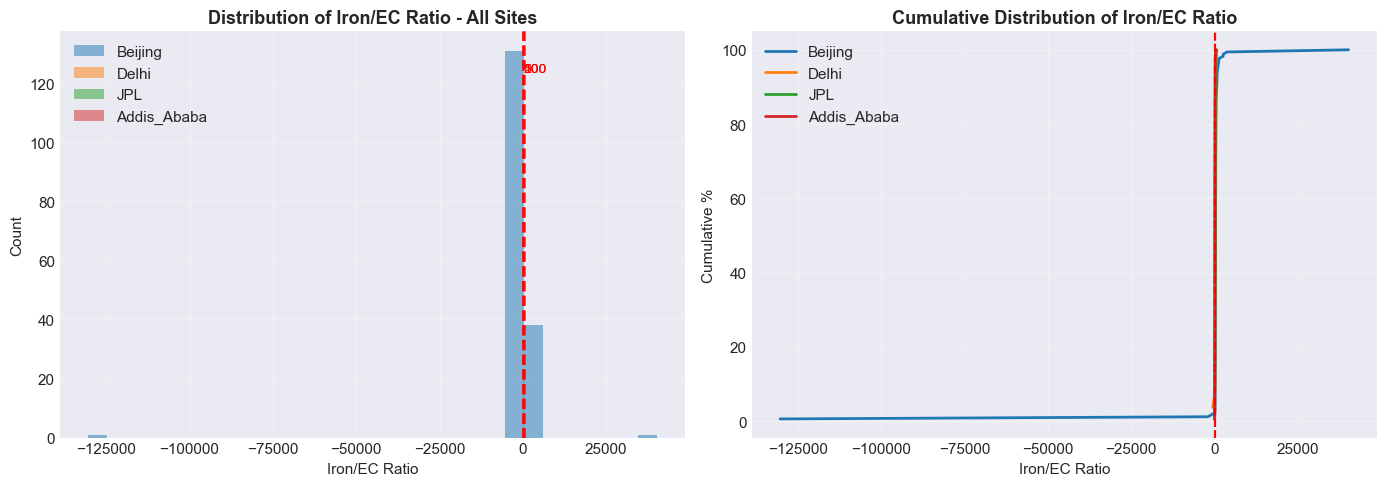

In [181]:
# Distribution of Iron/EC ratio
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax = axes[0]
for site_name in SITES:
    if site_name in all_params_data:
        site_ratio = all_params_data[site_name]['iron_ec_ratio'].dropna()
        if len(site_ratio) > 0:
            ax.hist(site_ratio, bins=30, alpha=0.5, label=site_name, color=SITE_COLORS.get(site_name))

# Add threshold lines
for thresh in [50, 100, 200]:
    ax.axvline(x=thresh, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax.text(thresh+5, ax.get_ylim()[1]*0.9, f'{thresh}', fontsize=10, color='red')

ax.set_xlabel('Iron/EC Ratio', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Distribution of Iron/EC Ratio - All Sites', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Cumulative distribution
ax = axes[1]
for site_name in SITES:
    if site_name in all_params_data:
        site_ratio = all_params_data[site_name]['iron_ec_ratio'].dropna()
        if len(site_ratio) > 0:
            sorted_vals = np.sort(site_ratio)
            cumulative = np.arange(1, len(sorted_vals)+1) / len(sorted_vals) * 100
            ax.plot(sorted_vals, cumulative, linewidth=2, label=site_name, color=SITE_COLORS.get(site_name))

for thresh in [50, 100, 200]:
    ax.axvline(x=thresh, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

ax.set_xlabel('Iron/EC Ratio', fontsize=11)
ax.set_ylabel('Cumulative %', fontsize=11)
ax.set_title('Cumulative Distribution of Iron/EC Ratio', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 1.1 Combined Plot: Aethalometer vs FTIR EC, Colored by Iron/EC Ratio

In [182]:
def plot_combined_iron_gradient(df, x_col, y_col, ratio_col, xlabel, ylabel, title,
                                 cmap='viridis', vmin=None, vmax=None):
    """
    Create a combined scatter plot with iron/EC ratio as color gradient.
    All sites plotted together.
    """
    # Filter to valid data
    valid_mask = df[x_col].notna() & df[y_col].notna() & df[ratio_col].notna()
    df_valid = df[valid_mask].copy()
    
    if len(df_valid) < 3:
        print("Insufficient data")
        return None
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    x = df_valid[x_col].values
    y = df_valid[y_col].values
    c = df_valid[ratio_col].values
    
    # Set color limits
    if vmin is None:
        vmin = np.percentile(c, 5)
    if vmax is None:
        vmax = np.percentile(c, 95)
    
    # Scatter plot
    scatter = ax.scatter(x, y, c=c, cmap=cmap, alpha=0.7, s=80,
                        edgecolors='black', linewidth=0.5,
                        vmin=vmin, vmax=vmax)
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('Iron/EC Ratio', fontsize=11)
    
    # Calculate regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Set axis limits from origin
    max_val = max(x.max(), y.max()) * 1.05
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    
    # Regression line
    x_line = np.array([0, max_val])
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, 'r-', linewidth=2, label=f'Fit: R²={r_value**2:.3f}, slope={slope:.3f}')
    
    # 1:1 line
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
    
    # Stats text
    sign = '+' if intercept >= 0 else '-'
    stats_text = f"n = {len(x)}\nR² = {r_value**2:.3f}\ny = {slope:.3f}x {sign} {abs(intercept):.2f}"
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.show()
    
    return {'n': len(x), 'r2': r_value**2, 'slope': slope, 'intercept': intercept}


COMBINED SITES: Aethalometer BC vs FTIR EC
Colored by Iron/EC Ratio


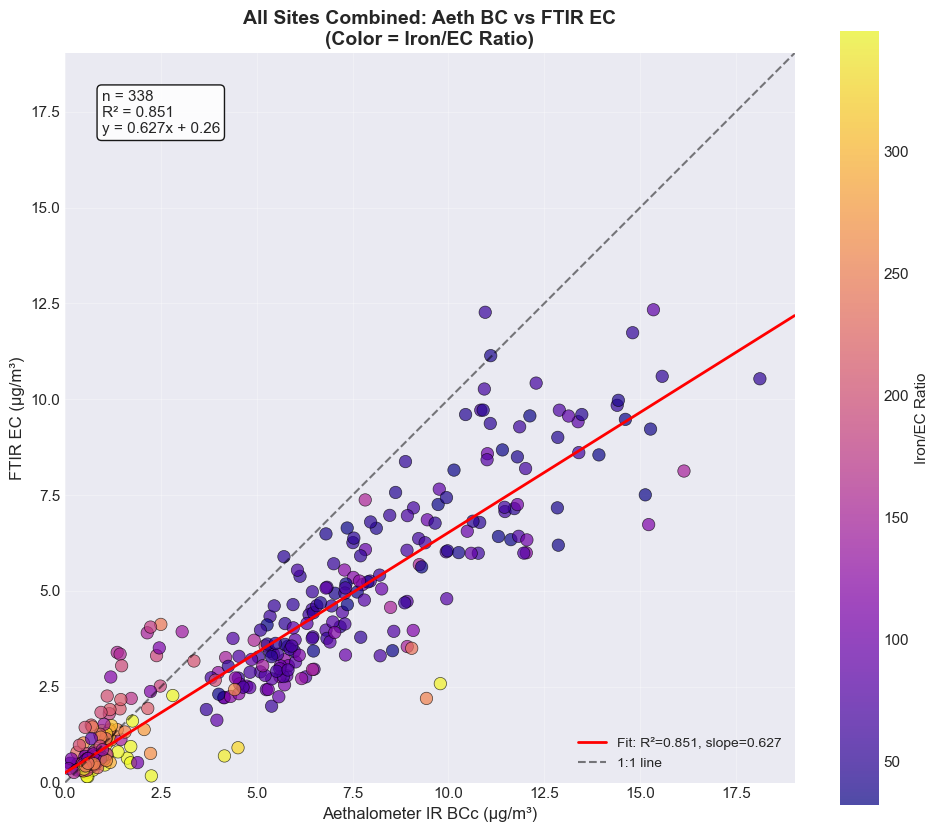

In [183]:
# Combined plot: Aethalometer vs FTIR EC, colored by Iron/EC ratio
print("\n" + "="*60)
print("COMBINED SITES: Aethalometer BC vs FTIR EC")
print("Colored by Iron/EC Ratio")
print("="*60)

results_combined = plot_combined_iron_gradient(
    combined_df,
    x_col='ir_bcc',
    y_col='ftir_ec',
    ratio_col='iron_ec_ratio',
    xlabel='Aethalometer IR BCc (µg/m³)',
    ylabel='FTIR EC (µg/m³)',
    title='All Sites Combined: Aeth BC vs FTIR EC\n(Color = Iron/EC Ratio)',
    cmap='plasma'
)

### 1.2 Threshold Analysis: Test Iron/EC Ratio Cutoffs (50, 100, 200)

In [184]:
def analyze_iron_threshold(df, x_col, y_col, ratio_col, threshold, xlabel, ylabel):
    """
    Analyze data split by iron/EC ratio threshold.
    Returns regression stats for low and high ratio groups.
    """
    # Filter to valid data
    valid_mask = df[x_col].notna() & df[y_col].notna() & df[ratio_col].notna()
    df_valid = df[valid_mask].copy()
    
    # Split by threshold
    low_ratio = df_valid[df_valid[ratio_col] <= threshold]
    high_ratio = df_valid[df_valid[ratio_col] > threshold]
    
    # Calculate axis limits
    all_vals = np.concatenate([df_valid[x_col].values, df_valid[y_col].values])
    max_val = all_vals.max() * 1.05
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    results = {'threshold': threshold}
    
    # Left: Low Iron/EC ratio
    ax = axes[0]
    if len(low_ratio) >= 3:
        x_low = low_ratio[x_col].values
        y_low = low_ratio[y_col].values
        ax.scatter(x_low, y_low, c='blue', alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
        
        slope, intercept, r_value, _, _ = stats.linregress(x_low, y_low)
        x_line = np.array([0, max_val])
        ax.plot(x_line, slope * x_line + intercept, 'b-', linewidth=2)
        
        results['low'] = {'n': len(x_low), 'r2': r_value**2, 'slope': slope}
        ax.text(0.05, 0.95, f"n={len(x_low)}\nR²={r_value**2:.3f}\nslope={slope:.3f}",
                transform=ax.transAxes, fontsize=10, va='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.9))
    
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f'LOW Iron/EC (≤{threshold})\nn={len(low_ratio)}', fontweight='bold')
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)
    
    # Middle: High Iron/EC ratio
    ax = axes[1]
    if len(high_ratio) >= 3:
        x_high = high_ratio[x_col].values
        y_high = high_ratio[y_col].values
        ax.scatter(x_high, y_high, c='red', alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
        
        slope, intercept, r_value, _, _ = stats.linregress(x_high, y_high)
        x_line = np.array([0, max_val])
        ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2)
        
        results['high'] = {'n': len(x_high), 'r2': r_value**2, 'slope': slope}
        ax.text(0.05, 0.95, f"n={len(x_high)}\nR²={r_value**2:.3f}\nslope={slope:.3f}",
                transform=ax.transAxes, fontsize=10, va='top',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.9))
    else:
        results['high'] = {'n': len(high_ratio), 'r2': np.nan, 'slope': np.nan}
        ax.text(0.5, 0.5, f'n={len(high_ratio)}\nInsufficient data', transform=ax.transAxes,
                ha='center', va='center', fontsize=12)
    
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f'HIGH Iron/EC (>{threshold})\nn={len(high_ratio)}', fontweight='bold')
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)
    
    # Right: Residual vs Iron/EC ratio
    ax = axes[2]
    residual = df_valid[y_col] - df_valid[x_col]
    ax.scatter(df_valid[ratio_col], residual, c='gray', alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold={threshold}')
    
    # Correlation
    corr, p_val = stats.pearsonr(df_valid[ratio_col], residual)
    ax.text(0.05, 0.95, f"Pearson r={corr:.3f}\np={p_val:.3e}",
            transform=ax.transAxes, fontsize=10, va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    results['residual_corr'] = corr
    results['residual_p'] = p_val
    
    ax.set_xlabel('Iron/EC Ratio')
    ax.set_ylabel(f'Residual ({ylabel.split(" ")[0]} - {xlabel.split(" ")[0]})')
    ax.set_title('Residual vs Iron/EC Ratio', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Iron/EC Threshold Analysis: {threshold}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return results


IRON/EC THRESHOLD ANALYSIS: Aethalometer BC vs FTIR EC
Testing thresholds: [50, 100, 150, 200, 300]

--- Threshold: 50 ---


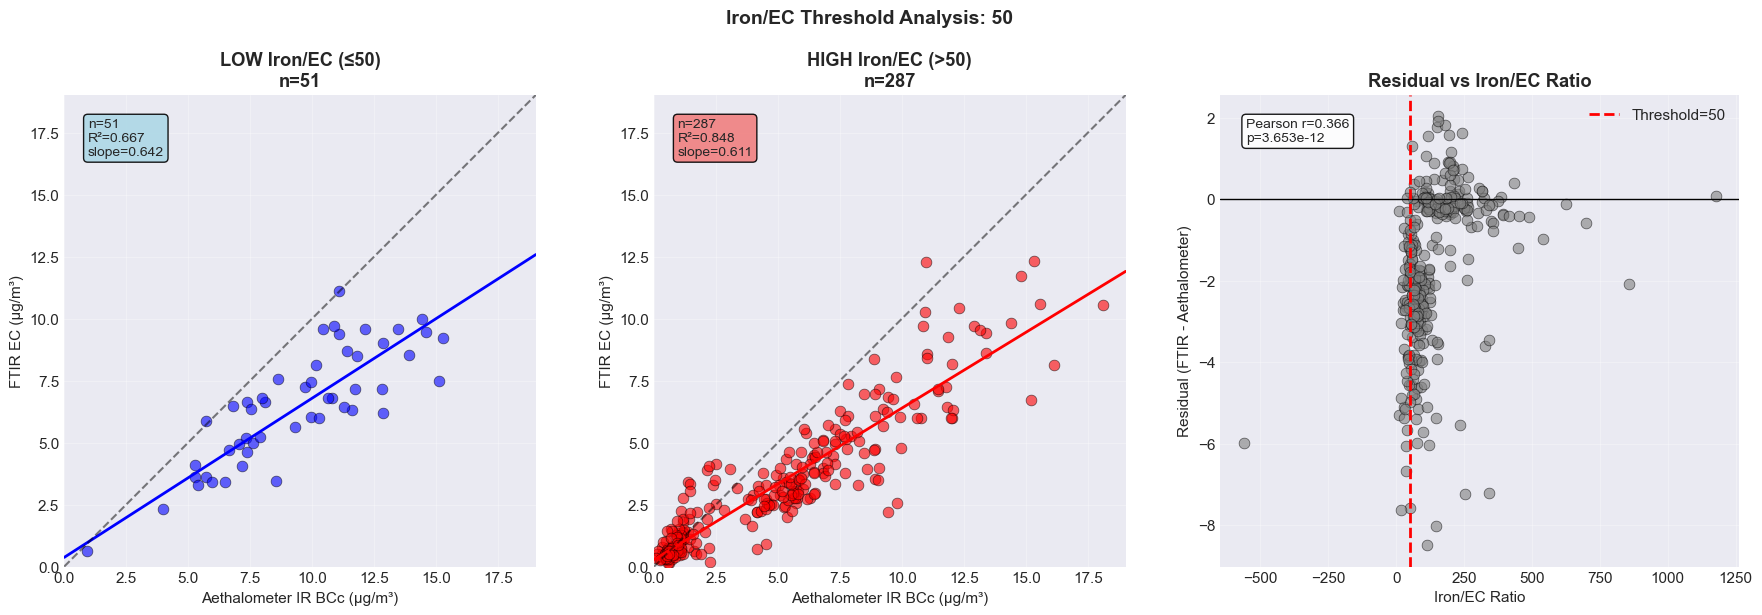


--- Threshold: 100 ---


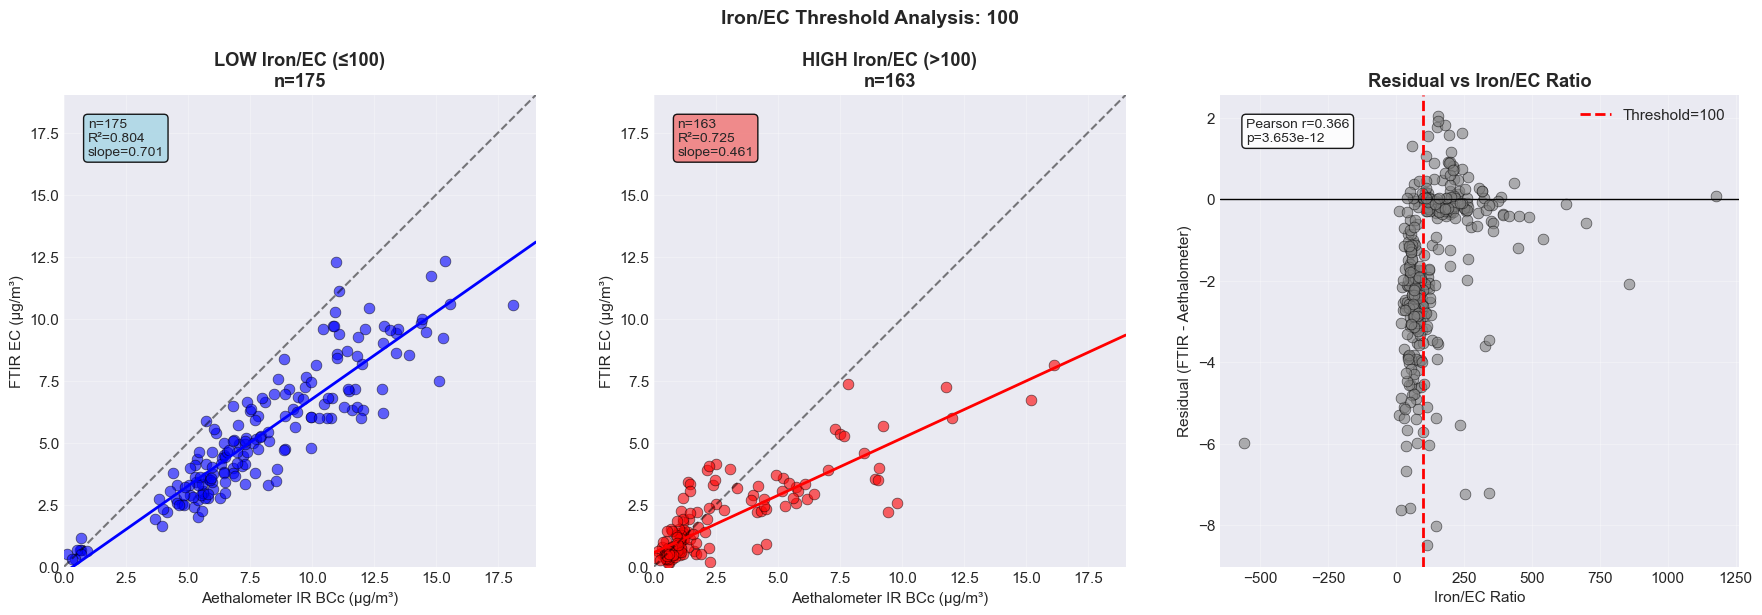


--- Threshold: 150 ---


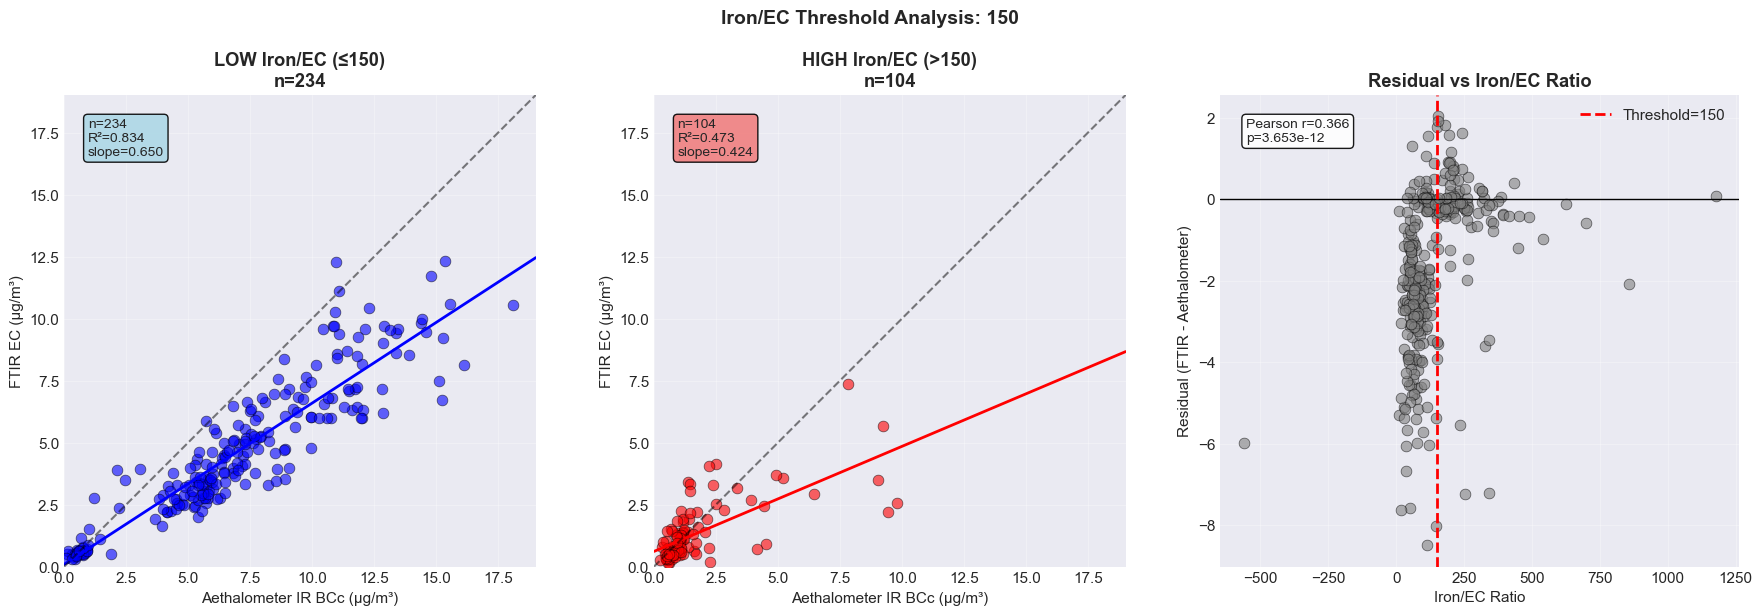


--- Threshold: 200 ---


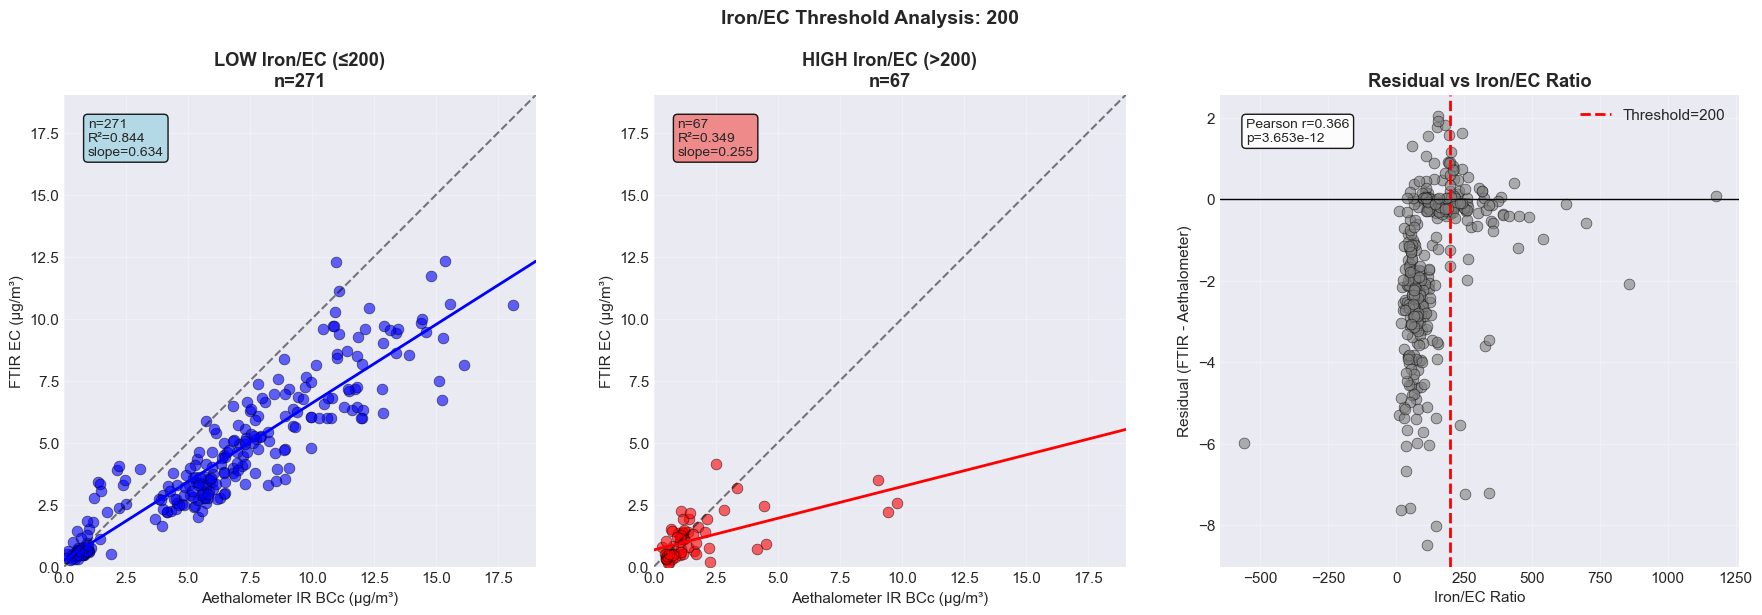


--- Threshold: 300 ---


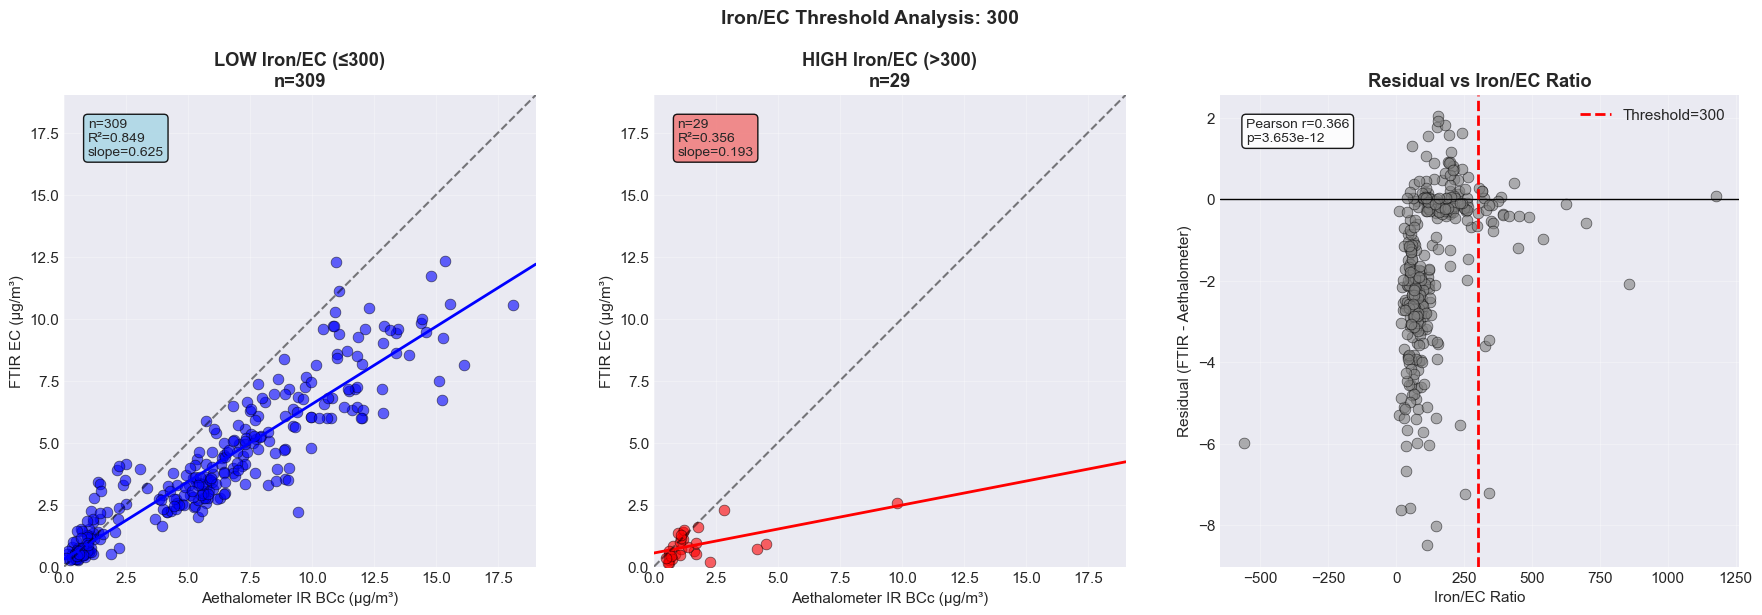

In [185]:
# Test multiple thresholds
IRON_EC_THRESHOLDS = [50, 100, 150, 200, 300]

print("\n" + "="*70)
print("IRON/EC THRESHOLD ANALYSIS: Aethalometer BC vs FTIR EC")
print("Testing thresholds:", IRON_EC_THRESHOLDS)
print("="*70)

threshold_results_aeth = {}

for threshold in IRON_EC_THRESHOLDS:
    print(f"\n--- Threshold: {threshold} ---")
    results = analyze_iron_threshold(
        combined_df,
        x_col='ir_bcc',
        y_col='ftir_ec',
        ratio_col='iron_ec_ratio',
        threshold=threshold,
        xlabel='Aethalometer IR BCc (µg/m³)',
        ylabel='FTIR EC (µg/m³)'
    )
    threshold_results_aeth[threshold] = results

In [186]:
# Summary table for threshold analysis
print("\n" + "="*80)
print("SUMMARY: Iron/EC Threshold Impact on Aethalometer vs FTIR EC")
print("="*80)
print(f"{'Threshold':<12s} {'Low n':<8s} {'Low R²':<10s} {'Low Slope':<12s} {'High n':<8s} {'High R²':<10s} {'High Slope':<12s} {'ΔR²':<10s}")
print("-" * 90)

for threshold, results in threshold_results_aeth.items():
    low = results.get('low', {})
    high = results.get('high', {})
    
    low_r2 = low.get('r2', np.nan)
    high_r2 = high.get('r2', np.nan)
    delta_r2 = low_r2 - high_r2 if not (np.isnan(low_r2) or np.isnan(high_r2)) else np.nan
    
    print(f"{threshold:<12d} {low.get('n', 0):<8d} {low_r2:<10.3f} {low.get('slope', np.nan):<12.3f} "
          f"{high.get('n', 0):<8d} {high_r2:<10.3f} {high.get('slope', np.nan):<12.3f} {delta_r2:<+10.3f}")


SUMMARY: Iron/EC Threshold Impact on Aethalometer vs FTIR EC
Threshold    Low n    Low R²     Low Slope    High n   High R²    High Slope   ΔR²       
------------------------------------------------------------------------------------------
50           51       0.667      0.642        287      0.848      0.611        -0.181    
100          175      0.804      0.701        163      0.725      0.461        +0.079    
150          234      0.834      0.650        104      0.473      0.424        +0.360    
200          271      0.844      0.634        67       0.349      0.255        +0.495    
300          309      0.849      0.625        29       0.356      0.193        +0.493    


### 1.3 Combined Filter: Iron/EC > 200 AND Aeth BC > 7.5 µg/m³

**Hypothesis**: High iron samples with high aethalometer BC readings may be most affected by iron interference. Test removing samples where BOTH:
- Iron/EC ratio > 200
- Aethalometer IR BCc > 7.5 µg/m³

In [187]:
# Show which samples would be excluded by Iron/EC + BC filter
print("\n" + "="*80)
print("SAMPLES TARGETED BY COMBINED FILTER")
print("="*80)

AETH_BC_CUTOFF = 7.5

# Filter to valid data
valid_mask = (combined_df['ir_bcc'].notna() & 
              combined_df['ftir_ec'].notna() & 
              combined_df['iron_ec_ratio'].notna())
df_valid = combined_df[valid_mask].copy()

print(f"\nTotal valid samples: {len(df_valid)}")

for threshold in [200, 300]:
    exclude_mask = (df_valid['iron_ec_ratio'] > threshold) & (df_valid['ir_bcc'] > AETH_BC_CUTOFF)
    n_excluded = exclude_mask.sum()
    
    print(f"\nIron/EC > {threshold} AND Aeth BC > {AETH_BC_CUTOFF}:")
    print(f"  Would exclude: {n_excluded} samples ({100*n_excluded/len(df_valid):.1f}%)")
    
    if n_excluded > 0:
        excluded = df_valid[exclude_mask]
        print(f"  By site:")
        for site in excluded['site'].unique():
            site_count = (excluded['site'] == site).sum()
            site_total = (df_valid['site'] == site).sum()
            print(f"    {site}: {site_count} of {site_total} ({100*site_count/site_total:.1f}%)")


SAMPLES TARGETED BY COMBINED FILTER

Total valid samples: 338

Iron/EC > 200 AND Aeth BC > 7.5:
  Would exclude: 3 samples (0.9%)
  By site:
    Delhi: 2 of 25 (8.0%)
    Addis_Ababa: 1 of 179 (0.6%)

Iron/EC > 300 AND Aeth BC > 7.5:
  Would exclude: 1 samples (0.3%)
  By site:
    Delhi: 1 of 25 (4.0%)



IRON/EC THRESHOLD WITH AETH BC EXCLUSION
For samples with Iron/EC > threshold, exclude those with Aeth BC > 7.5 µg/m³

THRESHOLD: Iron/EC > 200


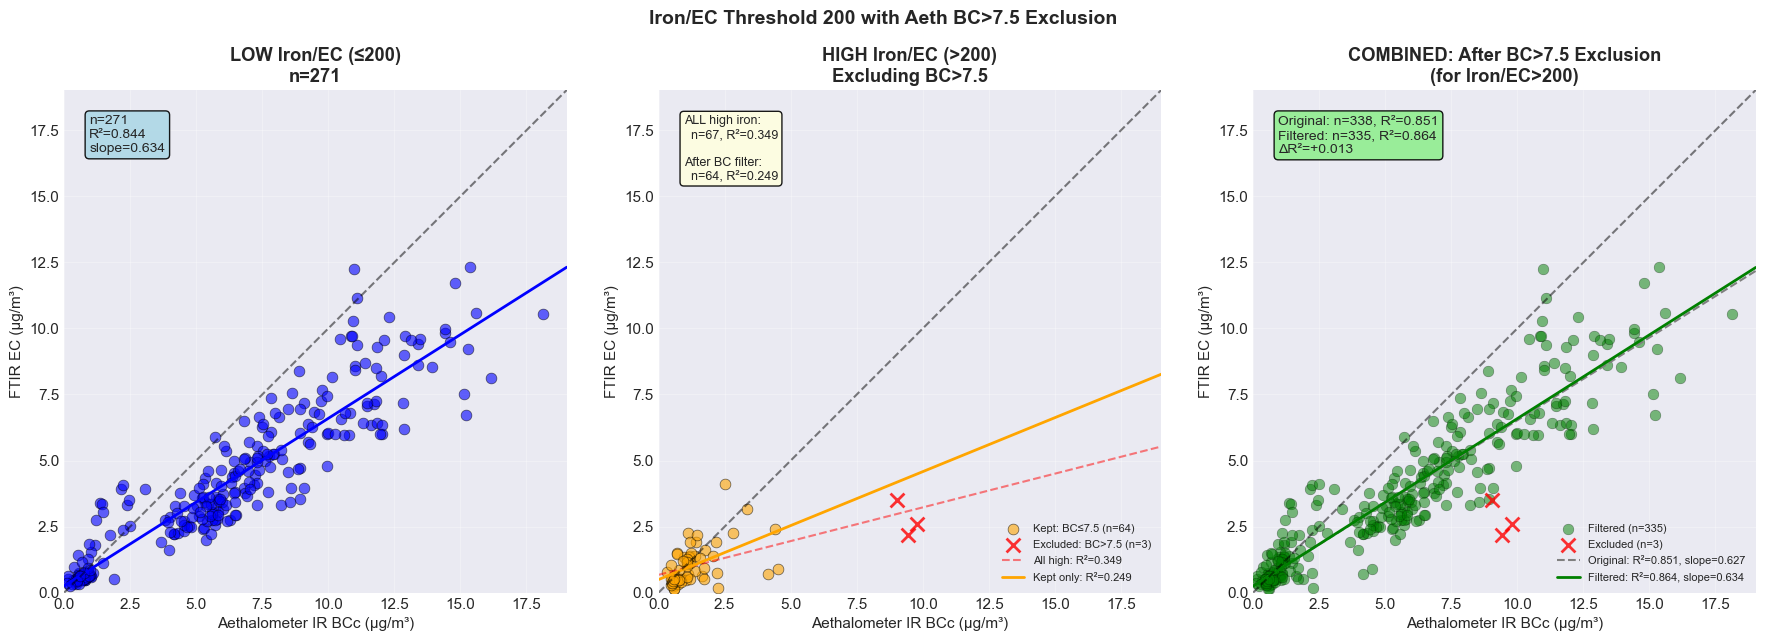


Excluded 3 samples with Iron/EC>200 AND BC>7.5
R² change: 0.851 → 0.864 (Δ=+0.013)
Slope change: 0.627 → 0.634

THRESHOLD: Iron/EC > 300


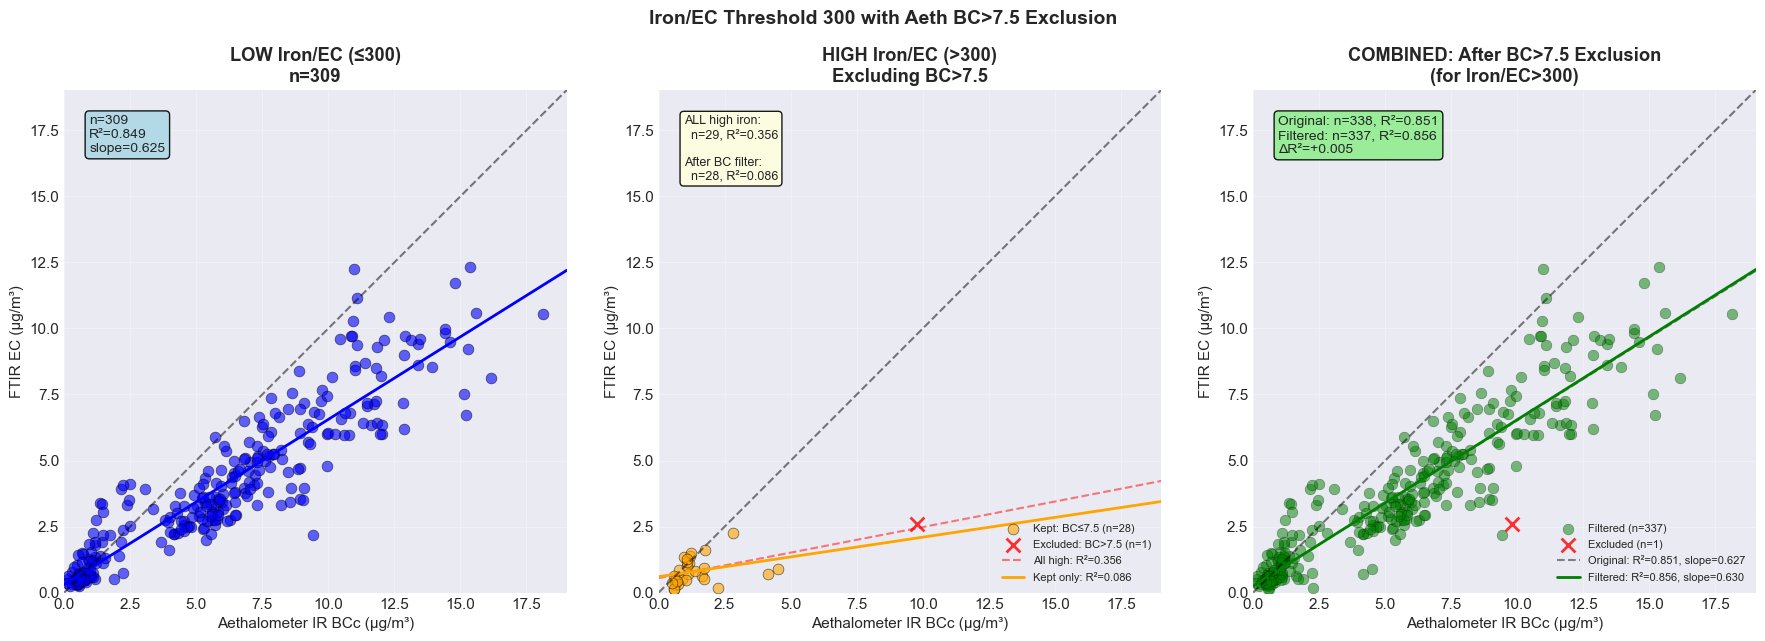


Excluded 1 samples with Iron/EC>300 AND BC>7.5
R² change: 0.851 → 0.856 (Δ=+0.005)
Slope change: 0.627 → 0.630


In [188]:
# Combined filter analysis with Iron/EC thresholds (200, 300) showing excluded points
# Similar to the standard threshold analysis but with Aeth BC filter applied

print("\n" + "="*80)
print("IRON/EC THRESHOLD WITH AETH BC EXCLUSION")
print("For samples with Iron/EC > threshold, exclude those with Aeth BC > 7.5 µg/m³")
print("="*80)

AETH_BC_CUTOFF = 7.5
THRESHOLDS_TO_SHOW = [200, 300]

for threshold in THRESHOLDS_TO_SHOW:
    print(f"\n{'='*70}")
    print(f"THRESHOLD: Iron/EC > {threshold}")
    print(f"{'='*70}")
    
    # Filter to valid data
    valid_mask = (combined_df['ir_bcc'].notna() & 
                  combined_df['ftir_ec'].notna() & 
                  combined_df['iron_ec_ratio'].notna())
    df_valid = combined_df[valid_mask].copy()
    
    # Identify samples to exclude (high iron AND high aeth BC)
    exclude_mask = (df_valid['iron_ec_ratio'] > threshold) & (df_valid['ir_bcc'] > AETH_BC_CUTOFF)
    n_excluded = exclude_mask.sum()
    
    # Split data
    low_ratio = df_valid[df_valid['iron_ec_ratio'] <= threshold]
    high_ratio_kept = df_valid[(df_valid['iron_ec_ratio'] > threshold) & (df_valid['ir_bcc'] <= AETH_BC_CUTOFF)]
    high_ratio_excluded = df_valid[exclude_mask]
    
    # Calculate axis limits
    all_vals = np.concatenate([df_valid['ir_bcc'].values, df_valid['ftir_ec'].values])
    max_val = np.nanmax(all_vals) * 1.05
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Left: Low Iron/EC ratio (unchanged)
    ax = axes[0]
    if len(low_ratio) >= 3:
        x_low = low_ratio['ir_bcc'].values
        y_low = low_ratio['ftir_ec'].values
        ax.scatter(x_low, y_low, c='blue', alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
        
        slope_low, intercept_low, r_low, _, _ = stats.linregress(x_low, y_low)
        x_line = np.array([0, max_val])
        ax.plot(x_line, slope_low * x_line + intercept_low, 'b-', linewidth=2)
        
        ax.text(0.05, 0.95, f"n={len(x_low)}\nR²={r_low**2:.3f}\nslope={slope_low:.3f}",
                transform=ax.transAxes, fontsize=10, va='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.9))
    
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_xlabel('Aethalometer IR BCc (µg/m³)')
    ax.set_ylabel('FTIR EC (µg/m³)')
    ax.set_title(f'LOW Iron/EC (≤{threshold})\nn={len(low_ratio)}', fontweight='bold')
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)
    
    # Middle: High Iron/EC ratio - showing kept vs excluded
    ax = axes[1]
    
    # Plot kept high-iron samples (BC ≤ 7.5)
    if len(high_ratio_kept) > 0:
        x_kept = high_ratio_kept['ir_bcc'].values
        y_kept = high_ratio_kept['ftir_ec'].values
        ax.scatter(x_kept, y_kept, c='orange', alpha=0.6, s=60, edgecolors='black', linewidth=0.5,
                  label=f'Kept: BC≤{AETH_BC_CUTOFF} (n={len(x_kept)})')
    
    # Plot excluded high-iron samples (BC > 7.5) as red X
    if len(high_ratio_excluded) > 0:
        x_excl = high_ratio_excluded['ir_bcc'].values
        y_excl = high_ratio_excluded['ftir_ec'].values
        ax.scatter(x_excl, y_excl, c='red', alpha=0.8, s=100, marker='x', linewidth=2,
                  label=f'Excluded: BC>{AETH_BC_CUTOFF} (n={len(x_excl)})')
    
    # Regression on ALL high-iron (before exclusion)
    all_high = df_valid[df_valid['iron_ec_ratio'] > threshold]
    if len(all_high) >= 3:
        x_all_high = all_high['ir_bcc'].values
        y_all_high = all_high['ftir_ec'].values
        slope_all, intercept_all, r_all, _, _ = stats.linregress(x_all_high, y_all_high)
        ax.plot(x_line, slope_all * x_line + intercept_all, 'r--', linewidth=1.5, alpha=0.5,
               label=f'All high: R²={r_all**2:.3f}')
    
    # Regression on kept high-iron only (after exclusion)
    if len(high_ratio_kept) >= 3:
        x_kept = high_ratio_kept['ir_bcc'].values
        y_kept = high_ratio_kept['ftir_ec'].values
        slope_kept, intercept_kept, r_kept, _, _ = stats.linregress(x_kept, y_kept)
        ax.plot(x_line, slope_kept * x_line + intercept_kept, 'orange', linewidth=2,
               label=f'Kept only: R²={r_kept**2:.3f}')
        
        ax.text(0.05, 0.95, f"ALL high iron:\n  n={len(all_high)}, R²={r_all**2:.3f}\n\nAfter BC filter:\n  n={len(high_ratio_kept)}, R²={r_kept**2:.3f}",
                transform=ax.transAxes, fontsize=9, va='top',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_xlabel('Aethalometer IR BCc (µg/m³)')
    ax.set_ylabel('FTIR EC (µg/m³)')
    ax.set_title(f'HIGH Iron/EC (>{threshold})\nExcluding BC>{AETH_BC_CUTOFF}', fontweight='bold')
    ax.legend(loc='lower right', fontsize=8)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)
    
    # Right: Combined (Low + Kept High) vs Original
    ax = axes[2]
    
    # Original regression (all data)
    x_orig = df_valid['ir_bcc'].values
    y_orig = df_valid['ftir_ec'].values
    slope_orig, intercept_orig, r_orig, _, _ = stats.linregress(x_orig, y_orig)
    
    # Combined filtered data
    df_combined_filtered = pd.concat([low_ratio, high_ratio_kept])
    x_filt = df_combined_filtered['ir_bcc'].values
    y_filt = df_combined_filtered['ftir_ec'].values
    
    # Plot filtered data
    ax.scatter(x_filt, y_filt, c='green', alpha=0.5, s=60, edgecolors='black', linewidth=0.3,
              label=f'Filtered (n={len(x_filt)})')
    
    # Plot excluded as red X
    if len(high_ratio_excluded) > 0:
        ax.scatter(high_ratio_excluded['ir_bcc'].values, high_ratio_excluded['ftir_ec'].values,
                  c='red', alpha=0.8, s=100, marker='x', linewidth=2,
                  label=f'Excluded (n={len(high_ratio_excluded)})')
    
    # Regression lines
    ax.plot(x_line, slope_orig * x_line + intercept_orig, 'gray', linewidth=1.5, linestyle='--',
           label=f'Original: R²={r_orig**2:.3f}, slope={slope_orig:.3f}')
    
    if len(x_filt) >= 3:
        slope_filt, intercept_filt, r_filt, _, _ = stats.linregress(x_filt, y_filt)
        ax.plot(x_line, slope_filt * x_line + intercept_filt, 'green', linewidth=2,
               label=f'Filtered: R²={r_filt**2:.3f}, slope={slope_filt:.3f}')
        
        # Summary text
        ax.text(0.05, 0.95, f"Original: n={len(x_orig)}, R²={r_orig**2:.3f}\nFiltered: n={len(x_filt)}, R²={r_filt**2:.3f}\nΔR²={r_filt**2 - r_orig**2:+.3f}",
                transform=ax.transAxes, fontsize=10, va='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.9))
    
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_xlabel('Aethalometer IR BCc (µg/m³)')
    ax.set_ylabel('FTIR EC (µg/m³)')
    ax.set_title(f'COMBINED: After BC>{AETH_BC_CUTOFF} Exclusion\n(for Iron/EC>{threshold})', fontweight='bold')
    ax.legend(loc='lower right', fontsize=8)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Iron/EC Threshold {threshold} with Aeth BC>{AETH_BC_CUTOFF} Exclusion', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nExcluded {n_excluded} samples with Iron/EC>{threshold} AND BC>{AETH_BC_CUTOFF}")
    if len(x_filt) >= 3:
        print(f"R² change: {r_orig**2:.3f} → {r_filt**2:.3f} (Δ={r_filt**2 - r_orig**2:+.3f})")
        print(f"Slope change: {slope_orig:.3f} → {slope_filt:.3f}")

### 1.4 Iron/EC Ratio Coloring (Continuous Gradient)

Same threshold analysis as above, but with points colored by Iron/EC ratio as a continuous gradient to visualize the distribution pattern.


IRON/EC THRESHOLD WITH CONTINUOUS RATIO COLORING

THRESHOLD: Iron/EC > 200 (with ratio gradient coloring)


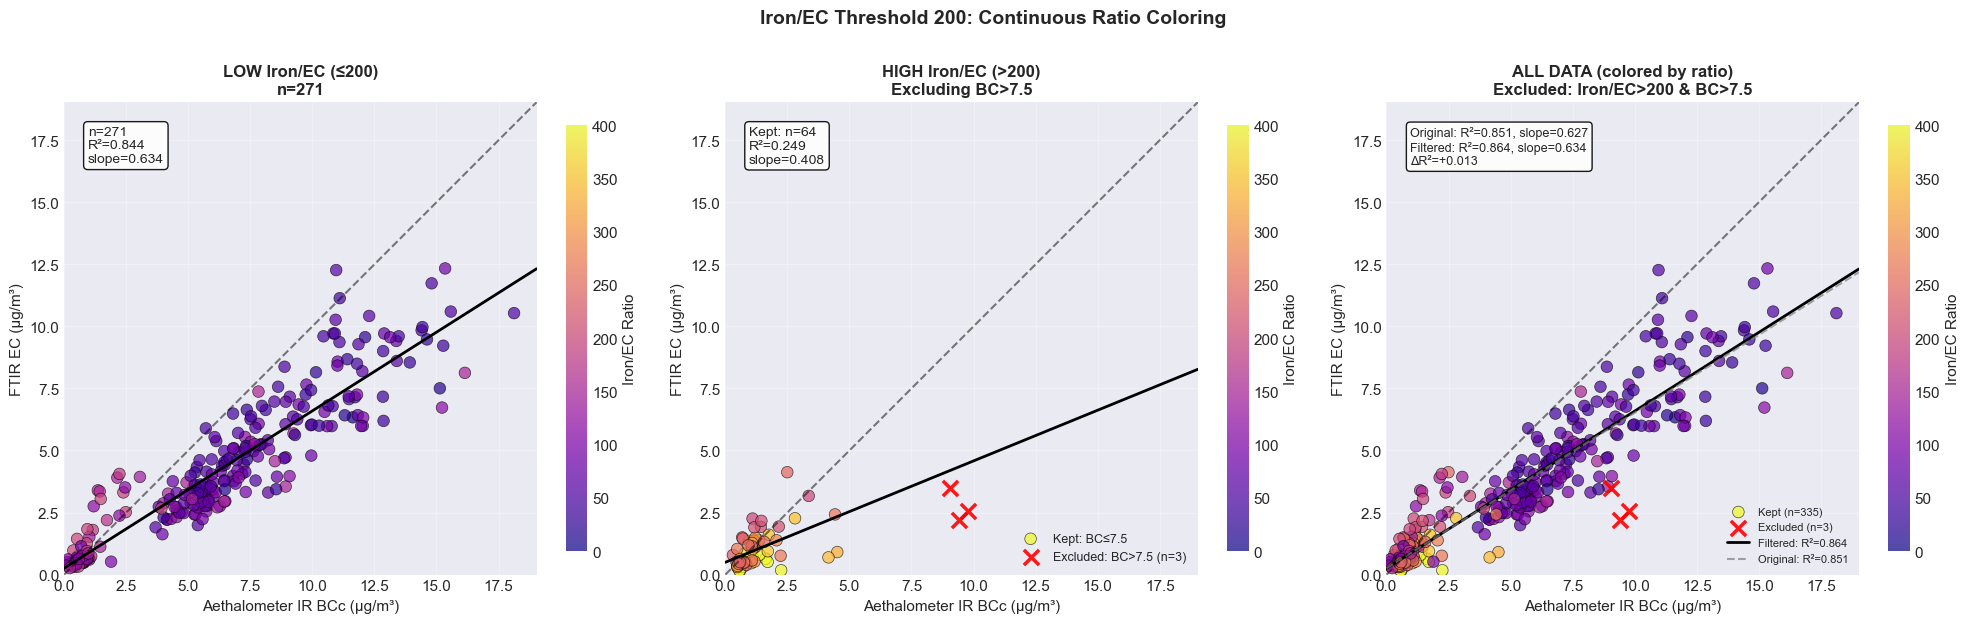


THRESHOLD: Iron/EC > 300 (with ratio gradient coloring)


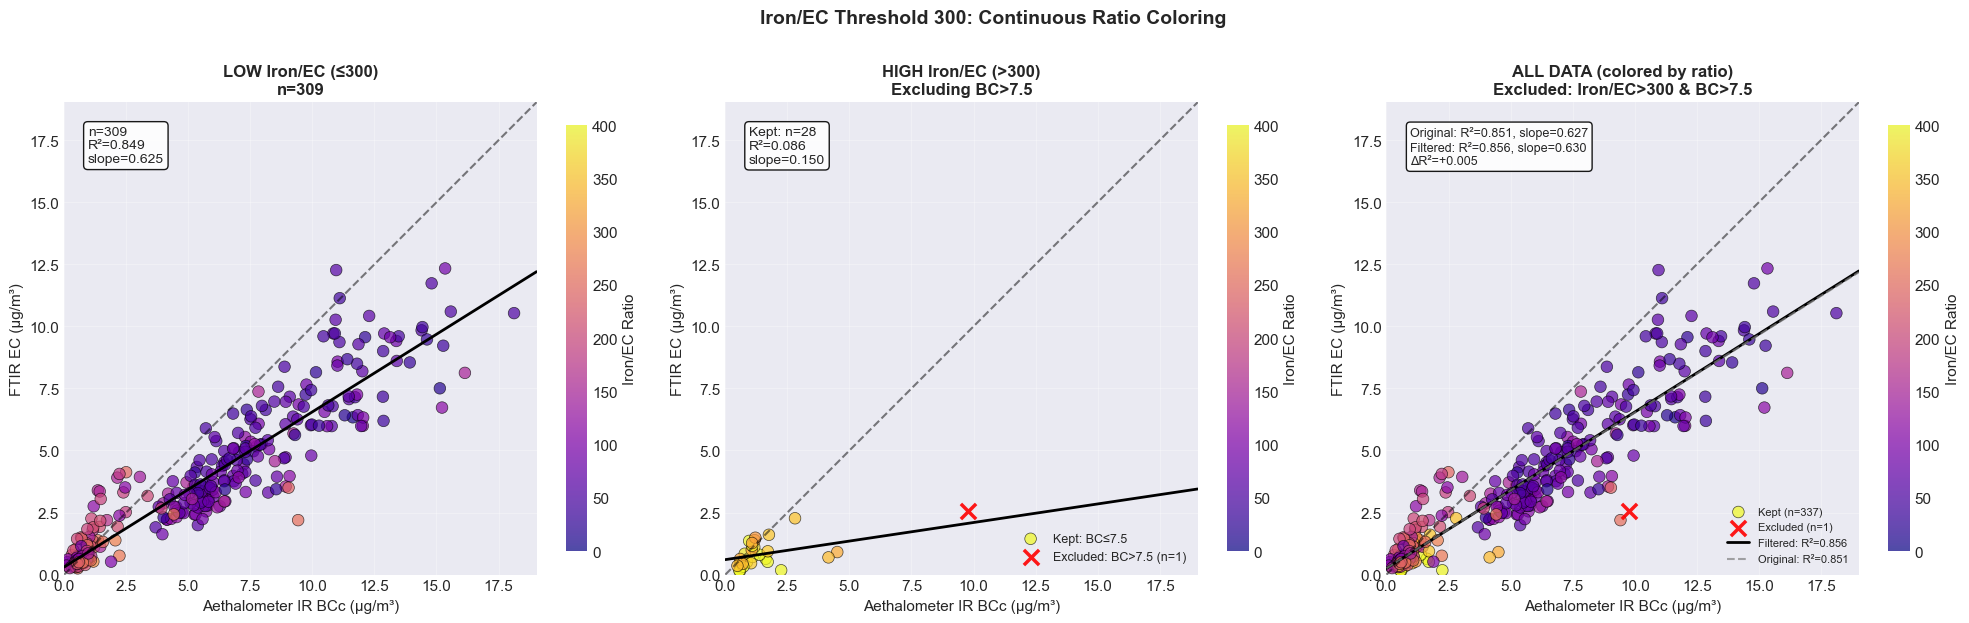

In [189]:
# Iron/EC threshold analysis with CONTINUOUS ratio coloring
# Points colored by Iron/EC ratio gradient

print("\n" + "="*80)
print("IRON/EC THRESHOLD WITH CONTINUOUS RATIO COLORING")
print("="*80)

AETH_BC_CUTOFF = 7.5
THRESHOLDS_TO_SHOW = [200, 300]

# Color settings
cmap = 'plasma'
vmin = 0
vmax = 400  # Cap at 400 for better color contrast

for threshold in THRESHOLDS_TO_SHOW:
    print(f"\n{'='*70}")
    print(f"THRESHOLD: Iron/EC > {threshold} (with ratio gradient coloring)")
    print(f"{'='*70}")
    
    # Filter to valid data
    valid_mask = (combined_df['ir_bcc'].notna() & 
                  combined_df['ftir_ec'].notna() & 
                  combined_df['iron_ec_ratio'].notna())
    df_valid = combined_df[valid_mask].copy()
    
    # Identify samples to exclude (high iron AND high aeth BC)
    exclude_mask = (df_valid['iron_ec_ratio'] > threshold) & (df_valid['ir_bcc'] > AETH_BC_CUTOFF)
    
    # Split data
    low_ratio = df_valid[df_valid['iron_ec_ratio'] <= threshold]
    high_ratio_kept = df_valid[(df_valid['iron_ec_ratio'] > threshold) & (df_valid['ir_bcc'] <= AETH_BC_CUTOFF)]
    high_ratio_excluded = df_valid[exclude_mask]
    
    # Calculate axis limits
    all_vals = np.concatenate([df_valid['ir_bcc'].values, df_valid['ftir_ec'].values])
    max_val = np.nanmax(all_vals) * 1.05
    x_line = np.array([0, max_val])
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Left: Low Iron/EC ratio - colored by ratio
    ax = axes[0]
    if len(low_ratio) >= 3:
        scatter = ax.scatter(low_ratio['ir_bcc'], low_ratio['ftir_ec'], 
                            c=low_ratio['iron_ec_ratio'], cmap=cmap, 
                            vmin=vmin, vmax=vmax,
                            alpha=0.7, s=70, edgecolors='black', linewidth=0.5)
        plt.colorbar(scatter, ax=ax, label='Iron/EC Ratio', shrink=0.8)
        
        slope_low, intercept_low, r_low, _, _ = stats.linregress(
            low_ratio['ir_bcc'].values, low_ratio['ftir_ec'].values)
        ax.plot(x_line, slope_low * x_line + intercept_low, 'k-', linewidth=2)
        
        ax.text(0.05, 0.95, f"n={len(low_ratio)}\nR²={r_low**2:.3f}\nslope={slope_low:.3f}",
                transform=ax.transAxes, fontsize=10, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_xlabel('Aethalometer IR BCc (µg/m³)', fontsize=11)
    ax.set_ylabel('FTIR EC (µg/m³)', fontsize=11)
    ax.set_title(f'LOW Iron/EC (≤{threshold})\nn={len(low_ratio)}', fontsize=12, fontweight='bold')
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)
    
    # Middle: High Iron/EC ratio - colored by ratio, excluded marked
    ax = axes[1]
    
    # Plot kept high-iron samples - colored by ratio
    if len(high_ratio_kept) > 0:
        scatter = ax.scatter(high_ratio_kept['ir_bcc'], high_ratio_kept['ftir_ec'],
                            c=high_ratio_kept['iron_ec_ratio'], cmap=cmap,
                            vmin=vmin, vmax=vmax,
                            alpha=0.7, s=70, edgecolors='black', linewidth=0.5,
                            label=f'Kept: BC≤{AETH_BC_CUTOFF}')
        plt.colorbar(scatter, ax=ax, label='Iron/EC Ratio', shrink=0.8)
    
    # Plot excluded samples as red X (regardless of ratio color)
    if len(high_ratio_excluded) > 0:
        ax.scatter(high_ratio_excluded['ir_bcc'], high_ratio_excluded['ftir_ec'],
                  c='red', alpha=0.9, s=120, marker='x', linewidth=2.5,
                  label=f'Excluded: BC>{AETH_BC_CUTOFF} (n={len(high_ratio_excluded)})')
    
    # Regression on kept only
    if len(high_ratio_kept) >= 3:
        slope_kept, intercept_kept, r_kept, _, _ = stats.linregress(
            high_ratio_kept['ir_bcc'].values, high_ratio_kept['ftir_ec'].values)
        ax.plot(x_line, slope_kept * x_line + intercept_kept, 'k-', linewidth=2)
        
        ax.text(0.05, 0.95, f"Kept: n={len(high_ratio_kept)}\nR²={r_kept**2:.3f}\nslope={slope_kept:.3f}",
                transform=ax.transAxes, fontsize=10, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_xlabel('Aethalometer IR BCc (µg/m³)', fontsize=11)
    ax.set_ylabel('FTIR EC (µg/m³)', fontsize=11)
    ax.set_title(f'HIGH Iron/EC (>{threshold})\nExcluding BC>{AETH_BC_CUTOFF}', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)
    
    # Right: ALL data colored by ratio, with excluded marked
    ax = axes[2]
    
    # Plot all valid data colored by ratio
    kept_mask = ~exclude_mask
    df_kept = df_valid[kept_mask]
    
    scatter = ax.scatter(df_kept['ir_bcc'], df_kept['ftir_ec'],
                        c=df_kept['iron_ec_ratio'], cmap=cmap,
                        vmin=vmin, vmax=vmax,
                        alpha=0.7, s=70, edgecolors='black', linewidth=0.5,
                        label=f'Kept (n={len(df_kept)})')
    plt.colorbar(scatter, ax=ax, label='Iron/EC Ratio', shrink=0.8)
    
    # Mark excluded points
    if len(high_ratio_excluded) > 0:
        ax.scatter(high_ratio_excluded['ir_bcc'], high_ratio_excluded['ftir_ec'],
                  c='red', alpha=0.9, s=120, marker='x', linewidth=2.5,
                  label=f'Excluded (n={len(high_ratio_excluded)})')
    
    # Regression on filtered data
    if len(df_kept) >= 3:
        slope_filt, intercept_filt, r_filt, _, _ = stats.linregress(
            df_kept['ir_bcc'].values, df_kept['ftir_ec'].values)
        ax.plot(x_line, slope_filt * x_line + intercept_filt, 'k-', linewidth=2,
               label=f'Filtered: R²={r_filt**2:.3f}')
        
        # Original regression for comparison
        slope_orig, intercept_orig, r_orig, _, _ = stats.linregress(
            df_valid['ir_bcc'].values, df_valid['ftir_ec'].values)
        ax.plot(x_line, slope_orig * x_line + intercept_orig, 'gray', linewidth=1.5, 
               linestyle='--', alpha=0.7, label=f'Original: R²={r_orig**2:.3f}')
        
        ax.text(0.05, 0.95, f"Original: R²={r_orig**2:.3f}, slope={slope_orig:.3f}\nFiltered: R²={r_filt**2:.3f}, slope={slope_filt:.3f}\nΔR²={r_filt**2 - r_orig**2:+.3f}",
                transform=ax.transAxes, fontsize=9, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_xlabel('Aethalometer IR BCc (µg/m³)', fontsize=11)
    ax.set_ylabel('FTIR EC (µg/m³)', fontsize=11)
    ax.set_title(f'ALL DATA (colored by ratio)\nExcluded: Iron/EC>{threshold} & BC>{AETH_BC_CUTOFF}', 
                fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=8)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Iron/EC Threshold {threshold}: Continuous Ratio Coloring', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


PER-SITE: FTIR EC vs Aethalometer BC (colored by Iron/EC ratio)


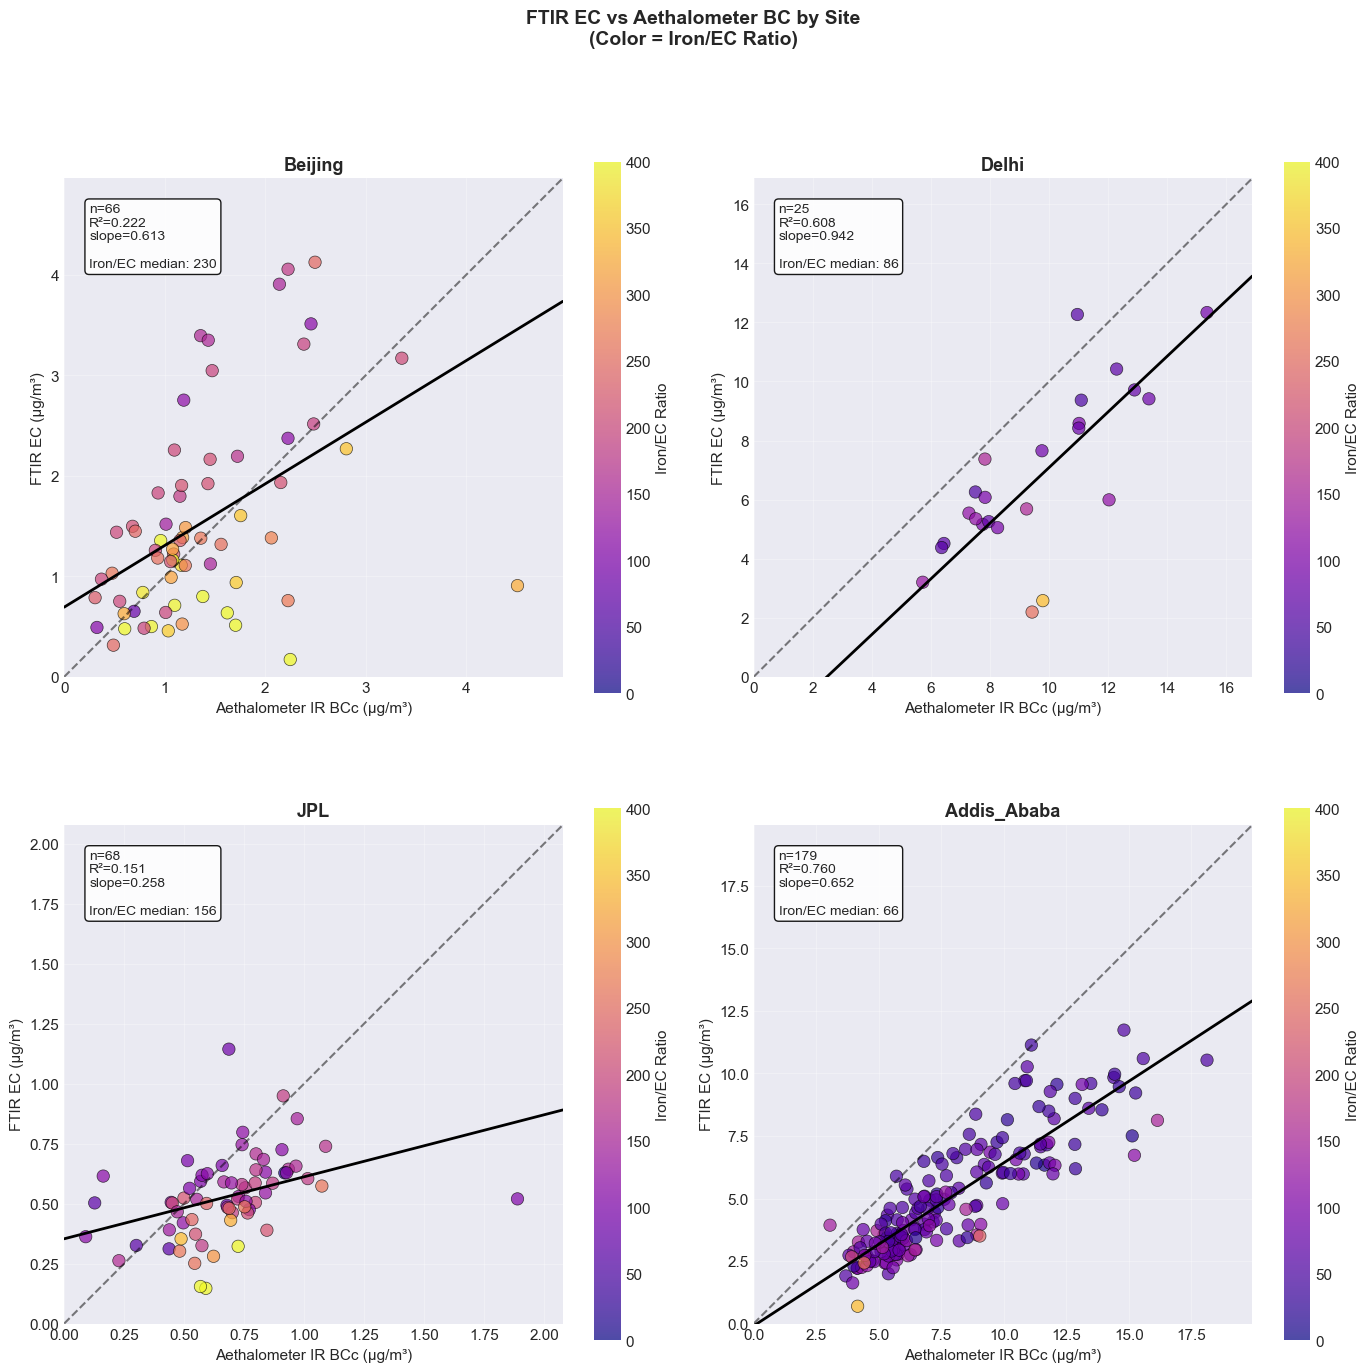

In [190]:
# Per-site breakdown with continuous ratio coloring
print("\n" + "="*80)
print("PER-SITE: FTIR EC vs Aethalometer BC (colored by Iron/EC ratio)")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

for idx, site_name in enumerate(['Beijing', 'Delhi', 'JPL', 'Addis_Ababa']):
    ax = axes[idx]
    
    if site_name not in all_params_data:
        ax.text(0.5, 0.5, f'{site_name}\nNo data', transform=ax.transAxes,
               ha='center', va='center', fontsize=14)
        ax.set_title(site_name, fontweight='bold')
        continue
    
    df = all_params_data[site_name]
    
    # Filter to valid data
    valid_mask = (df['ir_bcc'].notna() & 
                  df['ftir_ec'].notna() & 
                  df['iron_ec_ratio'].notna())
    df_plot = df[valid_mask]
    
    if len(df_plot) < 3:
        ax.text(0.5, 0.5, f'{site_name}\nInsufficient data (n={len(df_plot)})', 
               transform=ax.transAxes, ha='center', va='center', fontsize=14)
        ax.set_title(site_name, fontweight='bold')
        continue
    
    x = df_plot['ir_bcc'].values
    y = df_plot['ftir_ec'].values
    c = df_plot['iron_ec_ratio'].values
    
    # Scatter plot with ratio coloring
    scatter = ax.scatter(x, y, c=c, cmap='plasma', vmin=0, vmax=400,
                        alpha=0.7, s=80, edgecolors='black', linewidth=0.5)
    plt.colorbar(scatter, ax=ax, label='Iron/EC Ratio', shrink=0.8)
    
    # Calculate regression
    slope, intercept, r_value, _, _ = stats.linregress(x, y)
    
    # Axis limits
    max_val = max(x.max(), y.max()) * 1.1
    x_line = np.array([0, max_val])
    
    # Regression line
    ax.plot(x_line, slope * x_line + intercept, 'k-', linewidth=2)
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
    
    # Stats
    ax.text(0.05, 0.95, f"n={len(x)}\nR²={r_value**2:.3f}\nslope={slope:.3f}\n\nIron/EC median: {np.median(c):.0f}",
            transform=ax.transAxes, fontsize=10, va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_xlabel('Aethalometer IR BCc (µg/m³)', fontsize=11)
    ax.set_ylabel('FTIR EC (µg/m³)', fontsize=11)
    ax.set_title(f'{site_name}', fontsize=13, fontweight='bold')
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)

plt.suptitle('FTIR EC vs Aethalometer BC by Site\n(Color = Iron/EC Ratio)', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

---

# Task 2: HIPS-based Iron Analysis

**Goal**: Repeat the iron/EC ratio analysis using HIPS instead of aethalometer. HIPS correlates better with FTIR EC, which may remove confounding variables.


COMBINED SITES: HIPS vs FTIR EC
Colored by Iron/EC Ratio


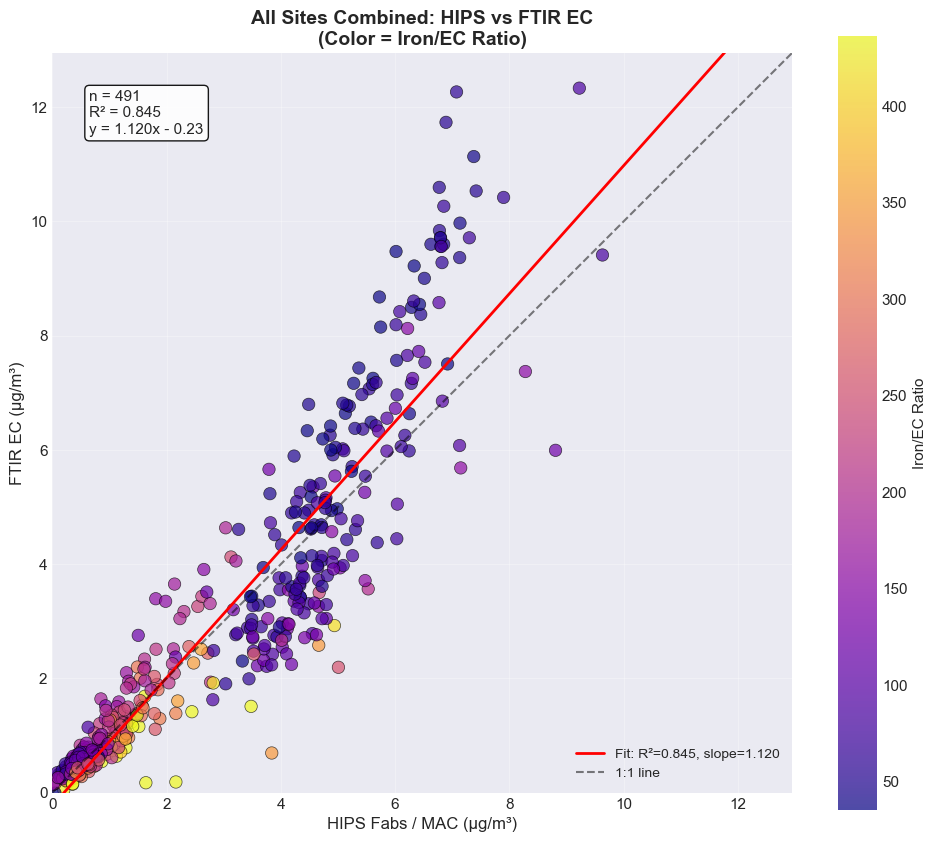

In [191]:
# Combined plot: HIPS vs FTIR EC, colored by Iron/EC ratio
print("\n" + "="*60)
print("COMBINED SITES: HIPS vs FTIR EC")
print("Colored by Iron/EC Ratio")
print("="*60)

results_hips_combined = plot_combined_iron_gradient(
    combined_df,
    x_col='hips_fabs',
    y_col='ftir_ec',
    ratio_col='iron_ec_ratio',
    xlabel='HIPS Fabs / MAC (µg/m³)',
    ylabel='FTIR EC (µg/m³)',
    title='All Sites Combined: HIPS vs FTIR EC\n(Color = Iron/EC Ratio)',
    cmap='plasma'
)


IRON/EC THRESHOLD ANALYSIS: HIPS vs FTIR EC
Testing thresholds: [50, 100, 150, 200, 300]

--- Threshold: 50 ---


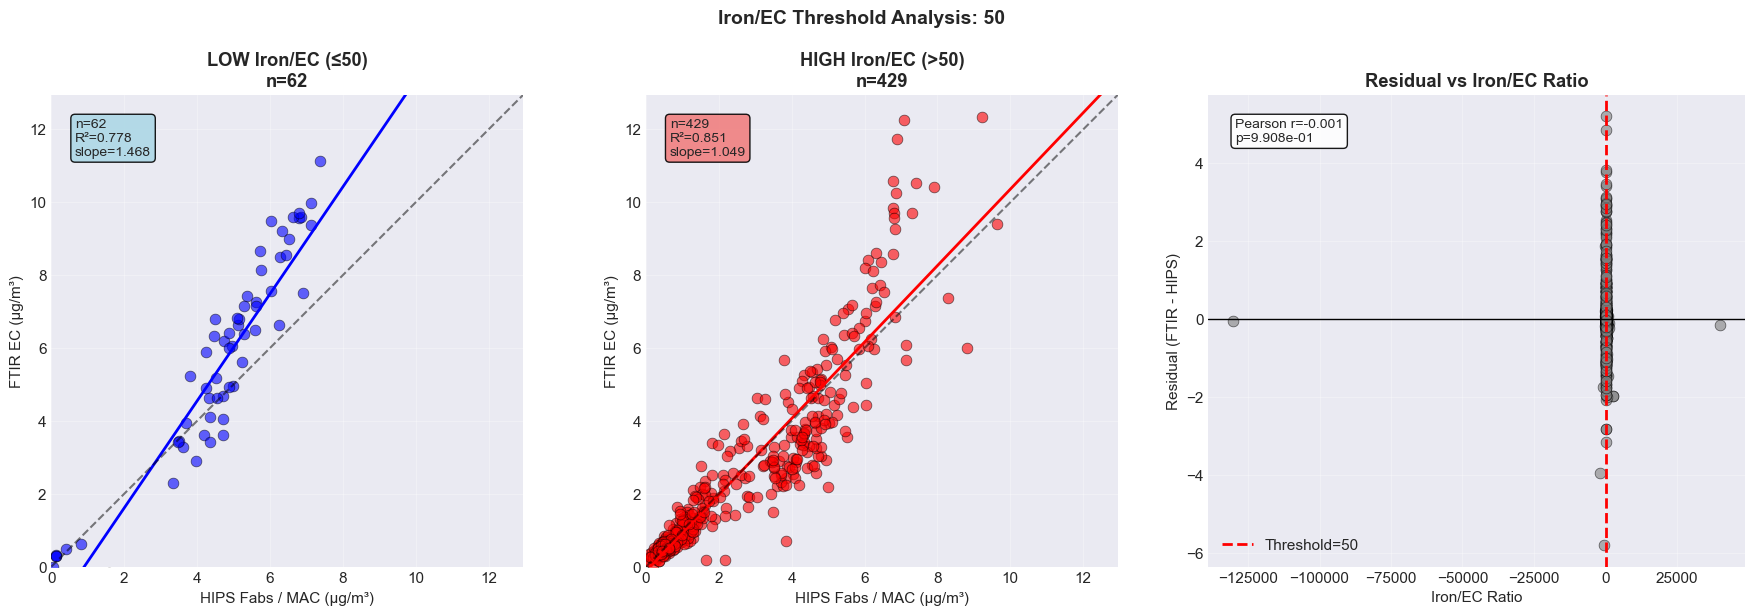


--- Threshold: 100 ---


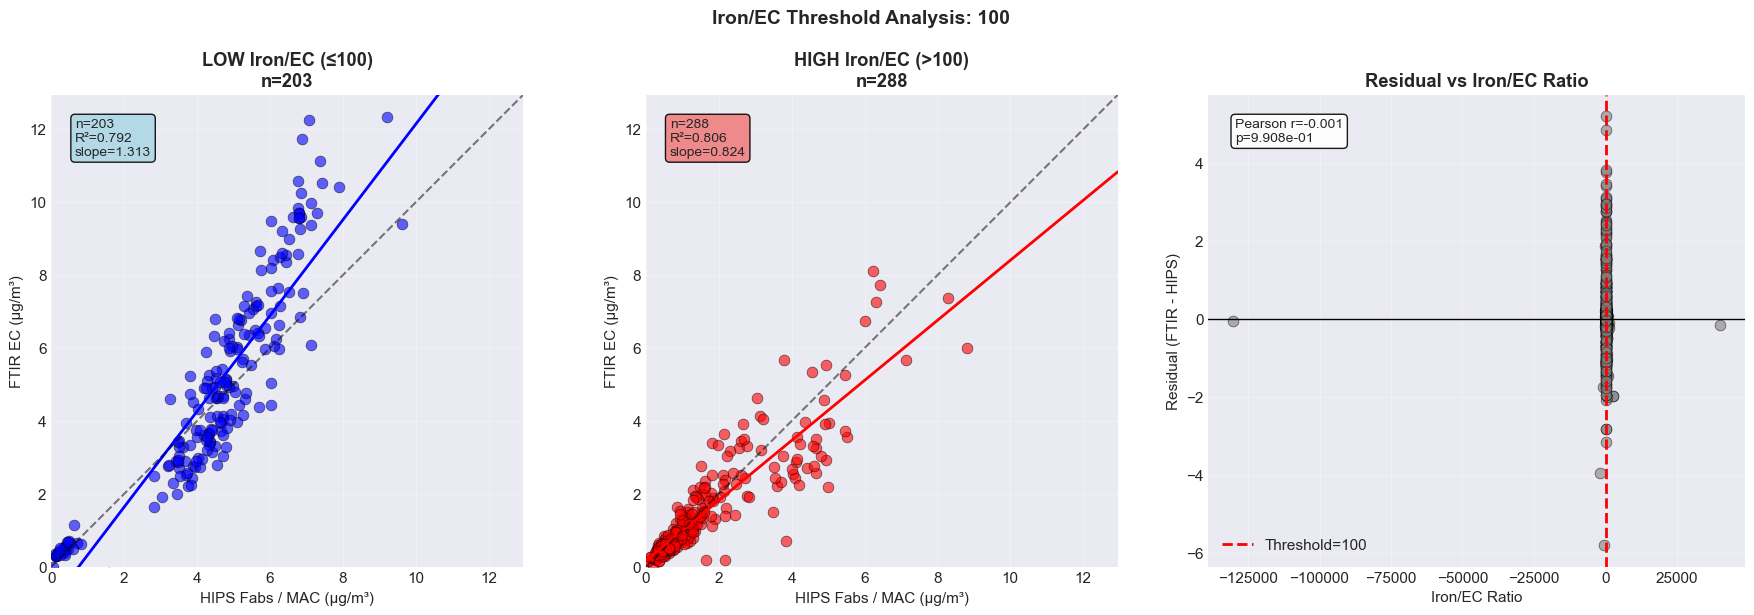


--- Threshold: 150 ---


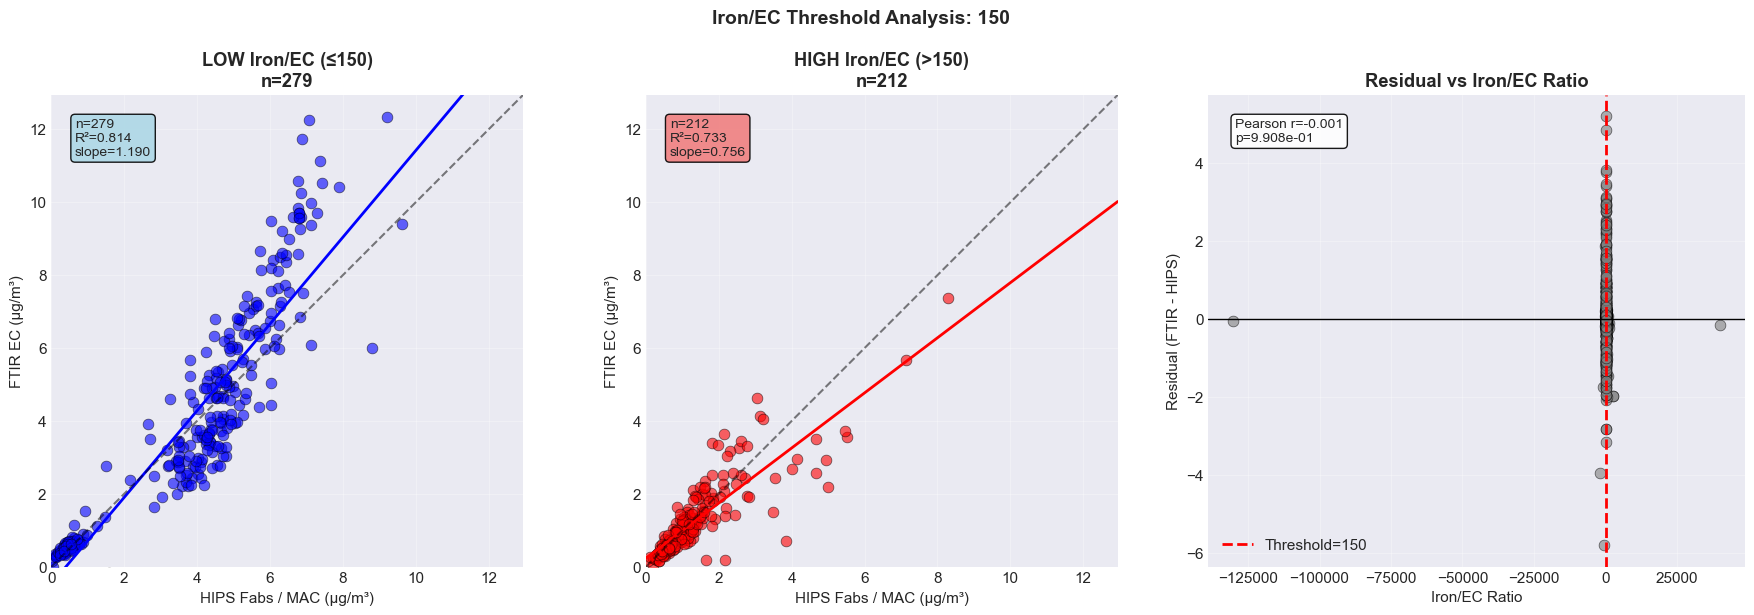


--- Threshold: 200 ---


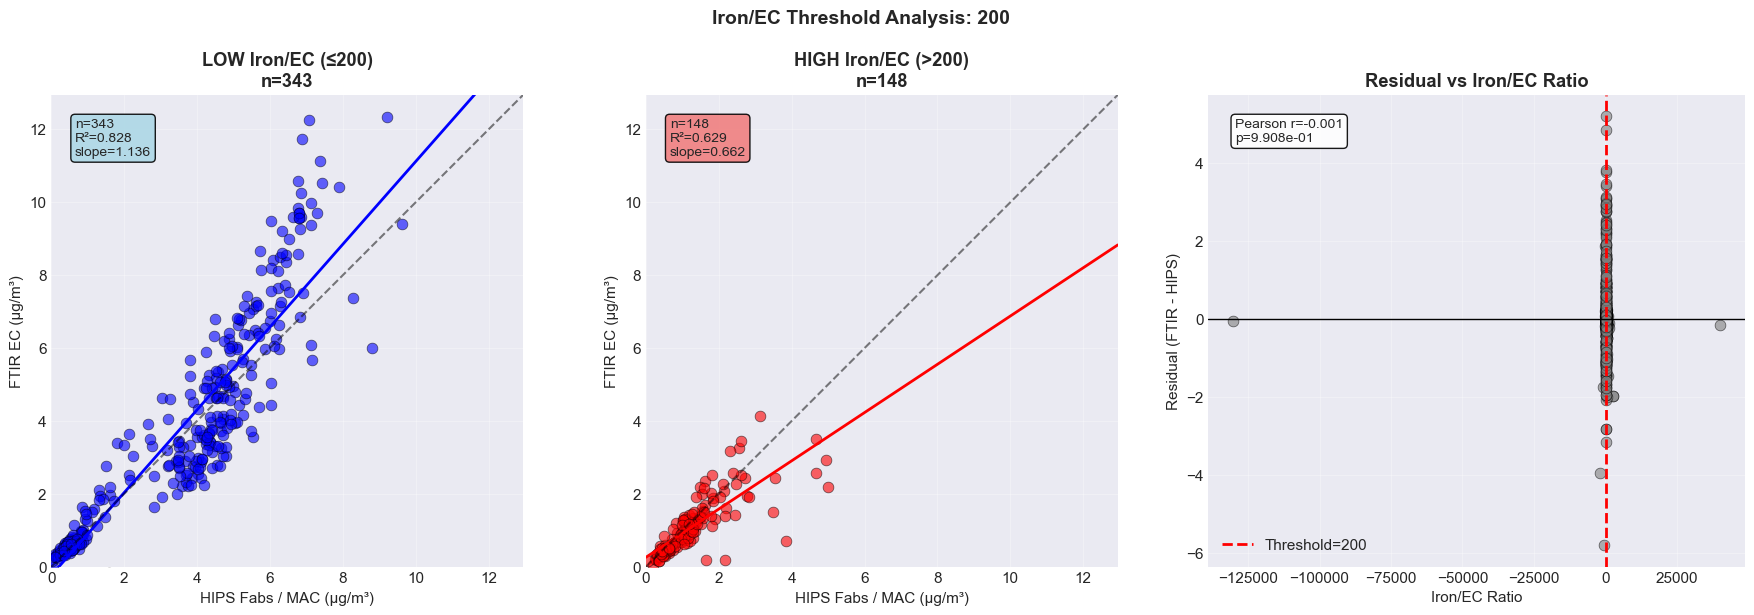


--- Threshold: 300 ---


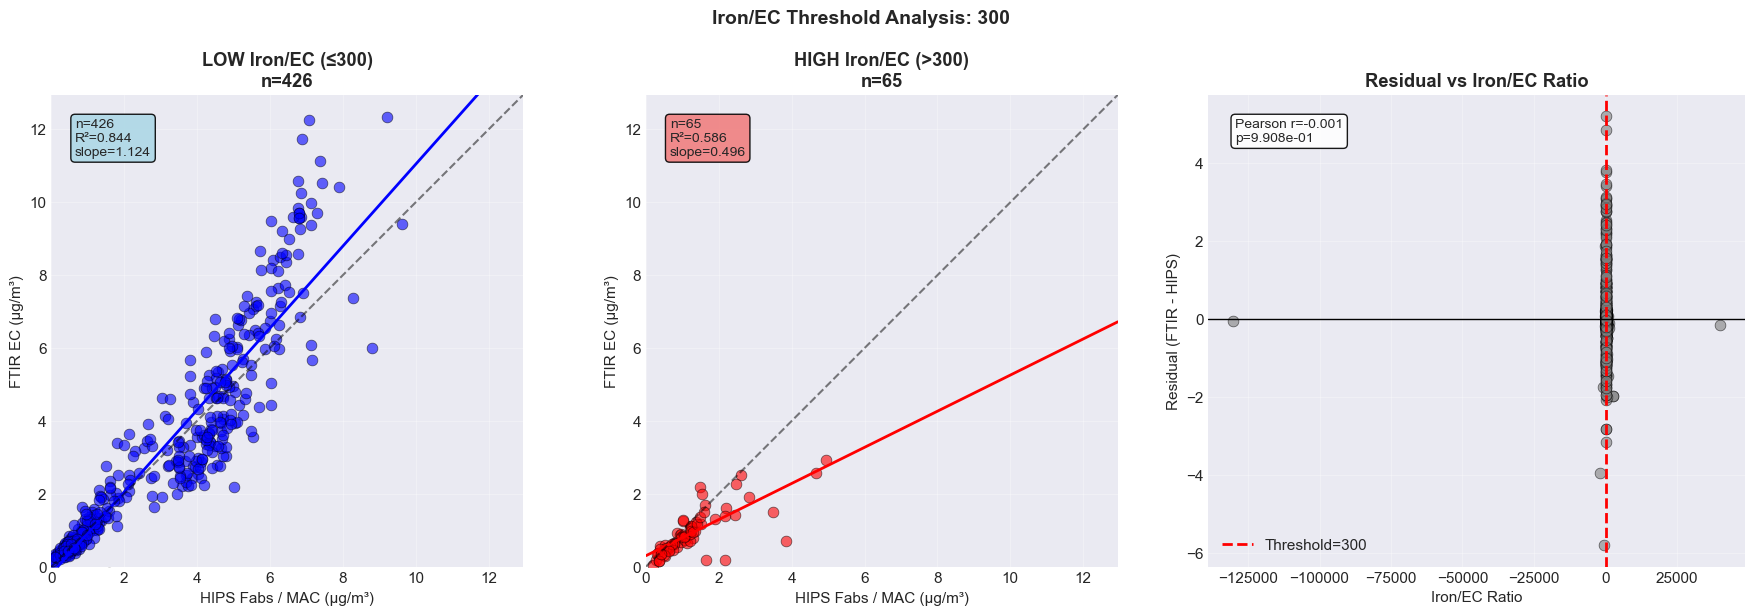

In [192]:
# HIPS threshold analysis
print("\n" + "="*70)
print("IRON/EC THRESHOLD ANALYSIS: HIPS vs FTIR EC")
print("Testing thresholds:", IRON_EC_THRESHOLDS)
print("="*70)

threshold_results_hips = {}

for threshold in IRON_EC_THRESHOLDS:
    print(f"\n--- Threshold: {threshold} ---")
    results = analyze_iron_threshold(
        combined_df,
        x_col='hips_fabs',
        y_col='ftir_ec',
        ratio_col='iron_ec_ratio',
        threshold=threshold,
        xlabel='HIPS Fabs / MAC (µg/m³)',
        ylabel='FTIR EC (µg/m³)'
    )
    threshold_results_hips[threshold] = results

In [193]:
# Summary table for HIPS threshold analysis
print("\n" + "="*80)
print("SUMMARY: Iron/EC Threshold Impact on HIPS vs FTIR EC")
print("="*80)
print(f"{'Threshold':<12s} {'Low n':<8s} {'Low R²':<10s} {'Low Slope':<12s} {'High n':<8s} {'High R²':<10s} {'High Slope':<12s} {'ΔR²':<10s}")
print("-" * 90)

for threshold, results in threshold_results_hips.items():
    low = results.get('low', {})
    high = results.get('high', {})
    
    low_r2 = low.get('r2', np.nan)
    high_r2 = high.get('r2', np.nan)
    delta_r2 = low_r2 - high_r2 if not (np.isnan(low_r2) or np.isnan(high_r2)) else np.nan
    
    print(f"{threshold:<12d} {low.get('n', 0):<8d} {low_r2:<10.3f} {low.get('slope', np.nan):<12.3f} "
          f"{high.get('n', 0):<8d} {high_r2:<10.3f} {high.get('slope', np.nan):<12.3f} {delta_r2:<+10.3f}")


SUMMARY: Iron/EC Threshold Impact on HIPS vs FTIR EC
Threshold    Low n    Low R²     Low Slope    High n   High R²    High Slope   ΔR²       
------------------------------------------------------------------------------------------
50           62       0.778      1.468        429      0.851      1.049        -0.073    
100          203      0.792      1.313        288      0.806      0.824        -0.015    
150          279      0.814      1.190        212      0.733      0.756        +0.081    
200          343      0.828      1.136        148      0.629      0.662        +0.199    
300          426      0.844      1.124        65       0.586      0.496        +0.258    


In [194]:
# Compare Aethalometer vs HIPS threshold results
print("\n" + "="*80)
print("COMPARISON: Aethalometer vs HIPS - Iron Threshold Impact")
print("="*80)
print("\nΔR² = R²(low iron) - R²(high iron)")
print("Positive ΔR² means low-iron samples have better correlation\n")

print(f"{'Threshold':<12s} {'Aeth ΔR²':<12s} {'HIPS ΔR²':<12s} {'Difference':<12s}")
print("-" * 50)

for threshold in IRON_EC_THRESHOLDS:
    aeth_low = threshold_results_aeth[threshold].get('low', {}).get('r2', np.nan)
    aeth_high = threshold_results_aeth[threshold].get('high', {}).get('r2', np.nan)
    aeth_delta = aeth_low - aeth_high if not (np.isnan(aeth_low) or np.isnan(aeth_high)) else np.nan
    
    hips_low = threshold_results_hips[threshold].get('low', {}).get('r2', np.nan)
    hips_high = threshold_results_hips[threshold].get('high', {}).get('r2', np.nan)
    hips_delta = hips_low - hips_high if not (np.isnan(hips_low) or np.isnan(hips_high)) else np.nan
    
    diff = aeth_delta - hips_delta if not (np.isnan(aeth_delta) or np.isnan(hips_delta)) else np.nan
    
    print(f"{threshold:<12d} {aeth_delta:<+12.3f} {hips_delta:<+12.3f} {diff:<+12.3f}")


COMPARISON: Aethalometer vs HIPS - Iron Threshold Impact

ΔR² = R²(low iron) - R²(high iron)
Positive ΔR² means low-iron samples have better correlation

Threshold    Aeth ΔR²     HIPS ΔR²     Difference  
--------------------------------------------------
50           -0.181       -0.073       -0.108      
100          +0.079       -0.015       +0.094      
150          +0.360       +0.081       +0.280      
200          +0.495       +0.199       +0.296      
300          +0.493       +0.258       +0.235      


---

# Task 3: Before/After Flow Fix Analysis (JPL Only)

**Goal**: Compare data from "before flow fix" and "after flow fix" periods to assess whether corrections improved measurement agreement.

## Data Availability Summary

| Site | Before Period | After Period | Filter Data Available | Suitable? |
|------|--------------|--------------|----------------------|-----------|
| **JPL** | ≤ Sep 30, 2022 | ≥ May 1, 2023 | Both periods | ✓ **Yes** |
| **Beijing** | ≤ Jul 31, 2022 | ≥ Sep 1, 2023 | Sep 2023+ only (after) | ✗ No |
| **Delhi** | ≤ Dec 31, 2023 | ≥ Feb 1, 2024 | Feb 2024+ only (after) | ✗ No |

**Key Finding**: Only JPL has filter data in BOTH before and after periods, making it the only site suitable for this comparison.

In [195]:
# Show flow fix period configuration and data availability
print("\n" + "="*60)
print("FLOW FIX PERIOD CONFIGURATION")
print("="*60)

# Use the flow_periods module's summary function
print_flow_period_summary()

# Also show which sites we can actually analyze
suitable_sites = [site for site, config in FLOW_FIX_PERIODS.items() 
                  if config.get('has_before_data', False)]
print(f"\n** Sites suitable for before/after analysis: {suitable_sites} **")
print("** Beijing and Delhi only have data in the 'after' period **")


FLOW FIX PERIOD CONFIGURATION
Flow Fix Analysis - Data Availability:

Beijing:
  Status: NO BEFORE DATA - Filter sampling started Sep 2023 (degraded period only)
  Flow ratio: Ratio ~1.8-2.2 in available data period
  ✗ NOT SUITABLE - no filter data in 'before' period

Delhi:
  Status: NO BEFORE DATA - Filter sampling started Feb 2024 (degraded period only)
  Flow ratio: Ratio ~2.5-3.2 in available data period
  ✗ NOT SUITABLE - no filter data in 'before' period

JPL:
  Status: Has data in both periods - suitable for before/after analysis
  Flow ratio: Good flow ratio throughout
  ✓ SUITABLE for before/after analysis
    Before: <= 2022-09-30
    After:  >= 2023-05-01

Sites suitable for before/after comparison: ['JPL']

** Sites suitable for before/after analysis: ['JPL'] **
** Beijing and Delhi only have data in the 'after' period **


In [196]:
def analyze_flow_periods(site_name, df, x_col, y_col, xlabel, ylabel, title_prefix):
    """
    Analyze before/after flow fix periods for a site.
    Creates side-by-side plots and returns regression stats.
    """
    flow_config = FLOW_FIX_PERIODS.get(site_name, {})
    before_end = flow_config.get('before_end')
    after_start = flow_config.get('after_start')
    
    if before_end is None and after_start is None:
        print(f"{site_name}: No flow fix periods defined")
        return None
    
    # Convert dates
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    before_end_dt = pd.to_datetime(before_end) if before_end else None
    after_start_dt = pd.to_datetime(after_start) if after_start else None
    
    # Classify periods
    def classify_period(date):
        if before_end_dt and date <= before_end_dt:
            return 'before_fix'
        elif after_start_dt and date >= after_start_dt:
            return 'after_fix'
        else:
            return 'gap_period'
    
    df['flow_period'] = df['date'].apply(classify_period)
    
    # Count samples
    period_counts = df['flow_period'].value_counts()
    print(f"\n{site_name} sample counts: {period_counts.to_dict()}")
    
    # Calculate axis limits
    valid_mask = df[x_col].notna() & df[y_col].notna()
    if valid_mask.sum() < 3:
        print(f"{site_name}: Insufficient data")
        return None
    
    all_vals = np.concatenate([df.loc[valid_mask, x_col].values, df.loc[valid_mask, y_col].values])
    max_val = all_vals.max() * 1.05
    
    results = {}
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    for ax, (period, label, color) in zip(axes, [
        ('before_fix', 'BEFORE Flow Fix', '#E74C3C'),
        ('after_fix', 'AFTER Flow Fix', '#2ECC71')
    ]):
        period_data = df[df['flow_period'] == period]
        
        if len(period_data) < 3:
            ax.text(0.5, 0.5, f'{label}\nn={len(period_data)}\nInsufficient data',
                    transform=ax.transAxes, ha='center', va='center', fontsize=14)
            results[period] = {'n': len(period_data), 'r2': np.nan, 'slope': np.nan}
        else:
            x = period_data[x_col].dropna()
            y = period_data.loc[x.index, y_col].dropna()
            common_idx = x.index.intersection(y.index)
            x, y = x[common_idx].values, period_data.loc[common_idx, y_col].values
            
            ax.scatter(x, y, c=color, alpha=0.6, s=80, edgecolors='black', linewidth=0.5,
                      label=f'{label} (n={len(x)})')
            
            if len(x) >= 3:
                slope, intercept, r_value, _, _ = stats.linregress(x, y)
                x_line = np.array([0, max_val])
                ax.plot(x_line, slope * x_line + intercept, color=color, linewidth=2,
                       label=f'R²={r_value**2:.3f}, slope={slope:.3f}')
                
                results[period] = {'n': len(x), 'r2': r_value**2, 'slope': slope, 'intercept': intercept}
                
                sign = '+' if intercept >= 0 else '-'
                stats_text = f"n = {len(x)}\nR² = {r_value**2:.3f}\ny = {slope:.3f}x {sign} {abs(intercept):.2f}"
                ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_xlabel(xlabel, fontsize=11)
        ax.set_ylabel(ylabel, fontsize=11)
        ax.set_title(f'{site_name}: {label}', fontsize=13, fontweight='bold')
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
    
    plt.suptitle(f'{title_prefix}: {site_name}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print comparison
    if 'before_fix' in results and 'after_fix' in results:
        before = results['before_fix']
        after = results['after_fix']
        if not np.isnan(before.get('r2', np.nan)) and not np.isnan(after.get('r2', np.nan)):
            print(f"\n  R² change: {before['r2']:.3f} → {after['r2']:.3f} (Δ = {after['r2'] - before['r2']:+.3f})")
            print(f"  Slope change: {before['slope']:.3f} → {after['slope']:.3f} (Δ = {after['slope'] - before['slope']:+.3f})")
    
    return results


FLOW PERIOD ANALYSIS: Aethalometer BC vs FTIR EC

Data Availability:
  JPL: Has data in BOTH before and after periods ✓
  Beijing: Filter data only from Sep 2023+ (all 'after' period)
  Delhi: Filter data only from Feb 2024+ (all 'after' period)


Site: JPL

JPL sample counts: {'before_fix': 102, 'after_fix': 83, 'gap_period': 68}


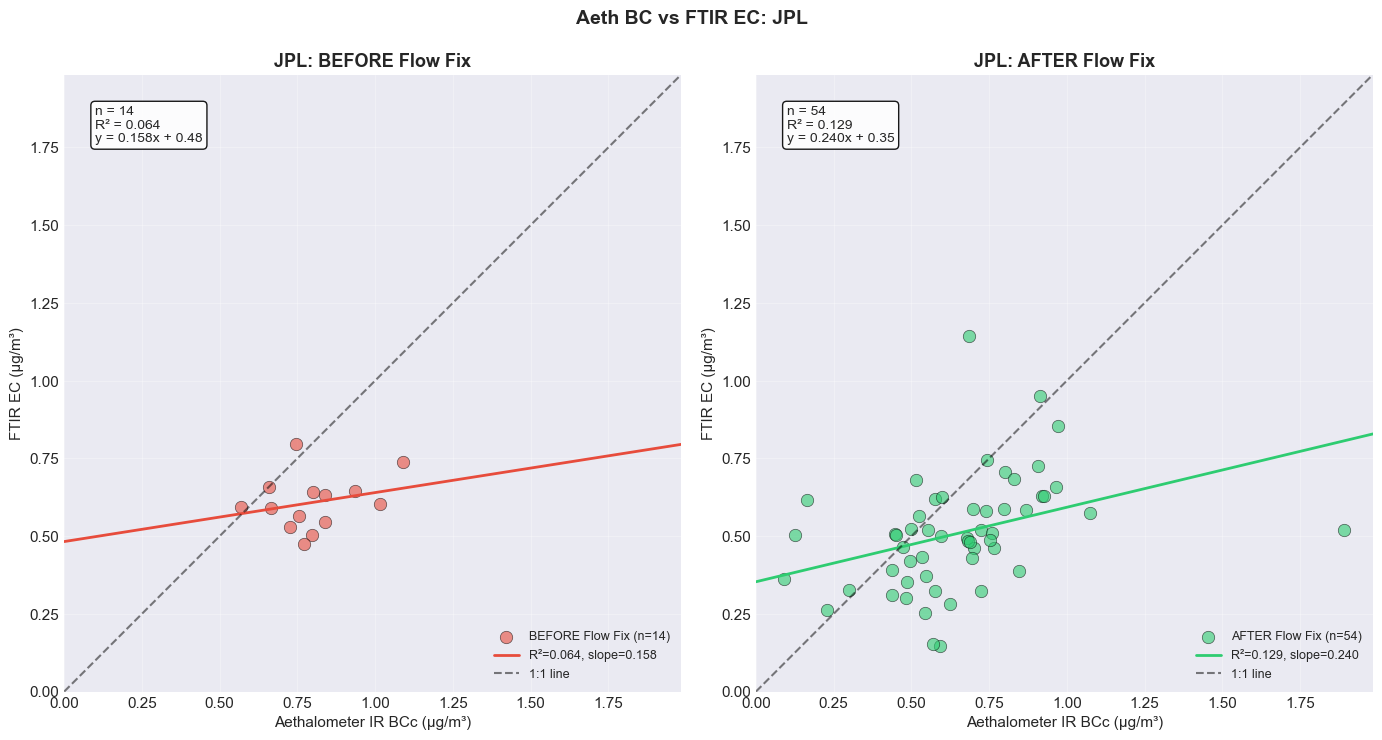


  R² change: 0.064 → 0.129 (Δ = +0.065)
  Slope change: 0.158 → 0.240 (Δ = +0.082)

Site: Beijing

Beijing sample counts: {'gap_period': 96, 'after_fix': 85, 'before_fix': 12}


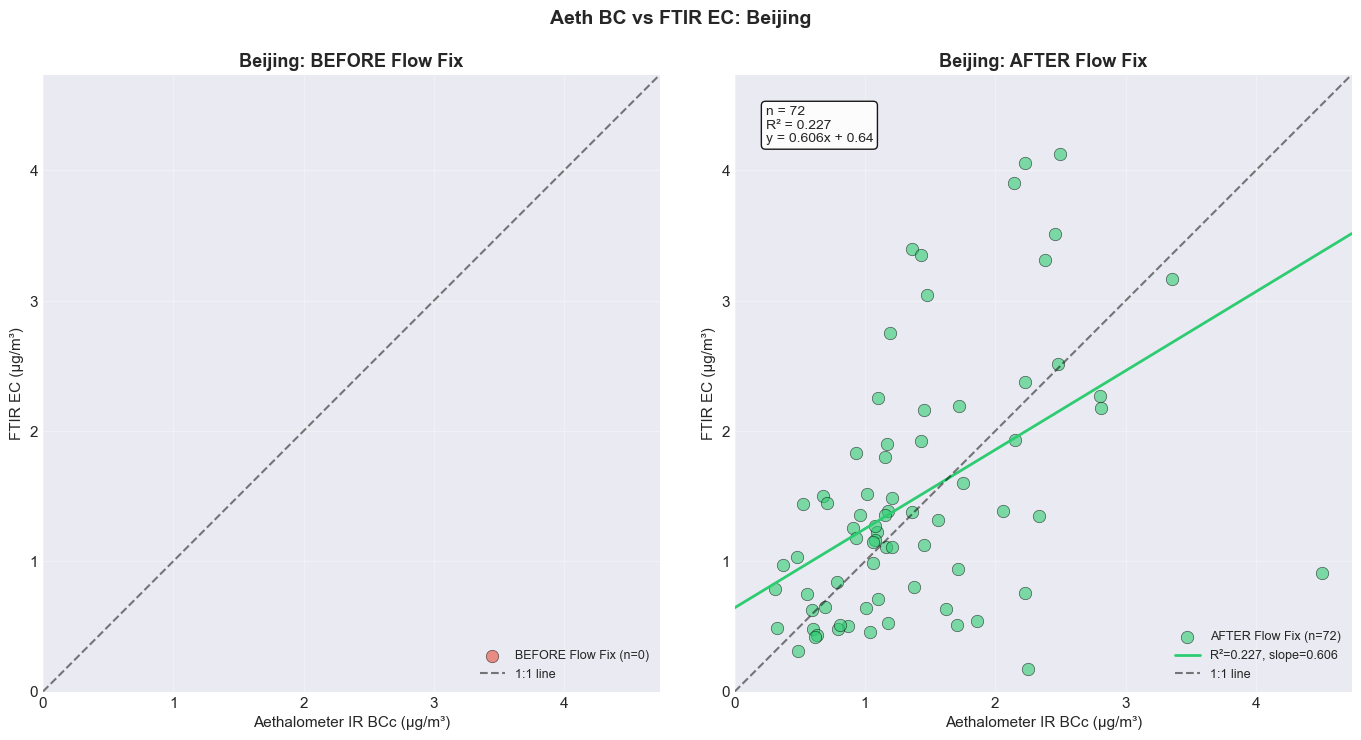


Site: Delhi

Delhi sample counts: {'after_fix': 34, 'before_fix': 29}


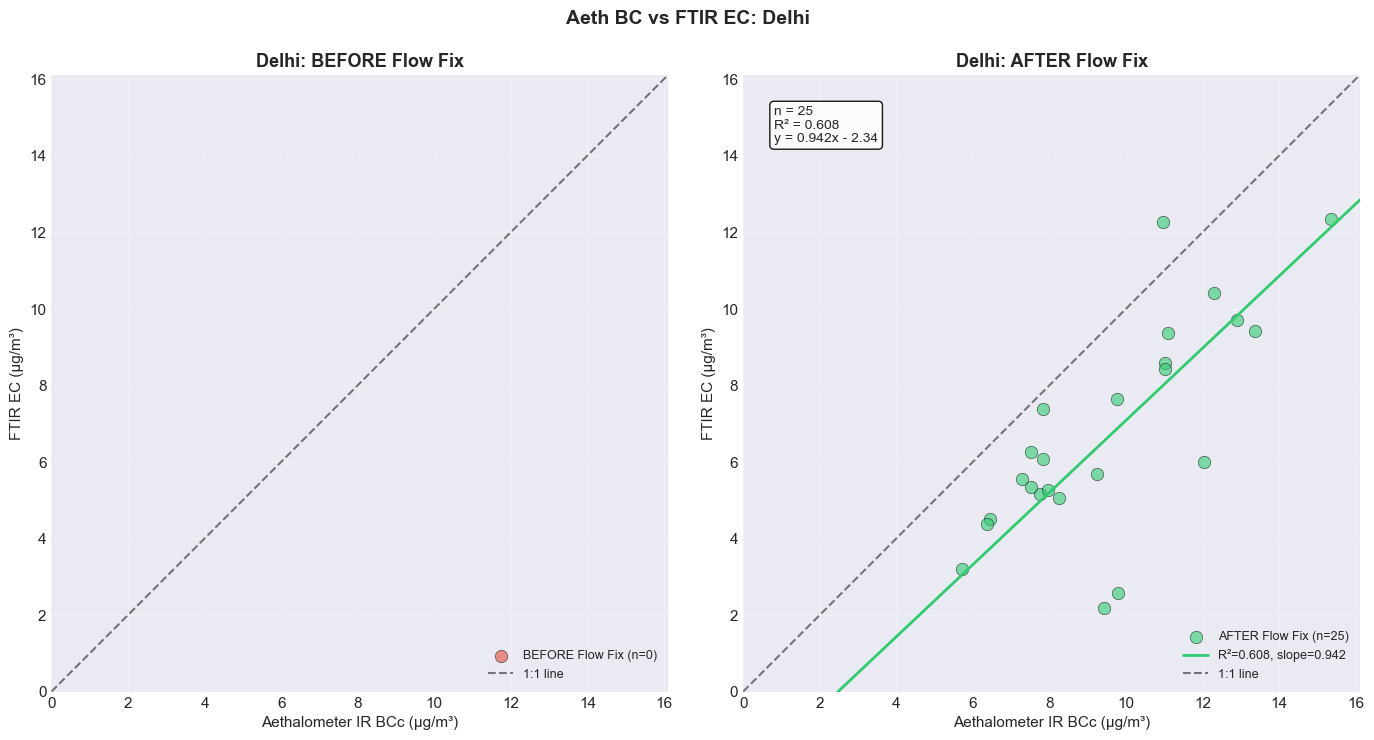

In [197]:
# Analyze flow periods for ALL sites (JPL, Beijing, Delhi)
# Note: Beijing and Delhi only have "after" period data

print("\n" + "="*70)
print("FLOW PERIOD ANALYSIS: Aethalometer BC vs FTIR EC")
print("="*70)
print("\nData Availability:")
print("  JPL: Has data in BOTH before and after periods ✓")
print("  Beijing: Filter data only from Sep 2023+ (all 'after' period)")
print("  Delhi: Filter data only from Feb 2024+ (all 'after' period)")
print()

flow_results_aeth = {}

# Analyze all sites with data
for site_name in ['JPL', 'Beijing', 'Delhi']:
    if site_name in all_params_data:
        print(f"\n{'='*50}")
        print(f"Site: {site_name}")
        print(f"{'='*50}")
        
        results = analyze_flow_periods(
            site_name,
            all_params_data[site_name],
            x_col='ir_bcc',
            y_col='ftir_ec',
            xlabel='Aethalometer IR BCc (µg/m³)',
            ylabel='FTIR EC (µg/m³)',
            title_prefix='Aeth BC vs FTIR EC'
        )
        if results:
            flow_results_aeth[site_name] = results


FLOW PERIOD ANALYSIS: HIPS vs FTIR EC

Site: JPL

JPL sample counts: {'before_fix': 102, 'after_fix': 83, 'gap_period': 68}


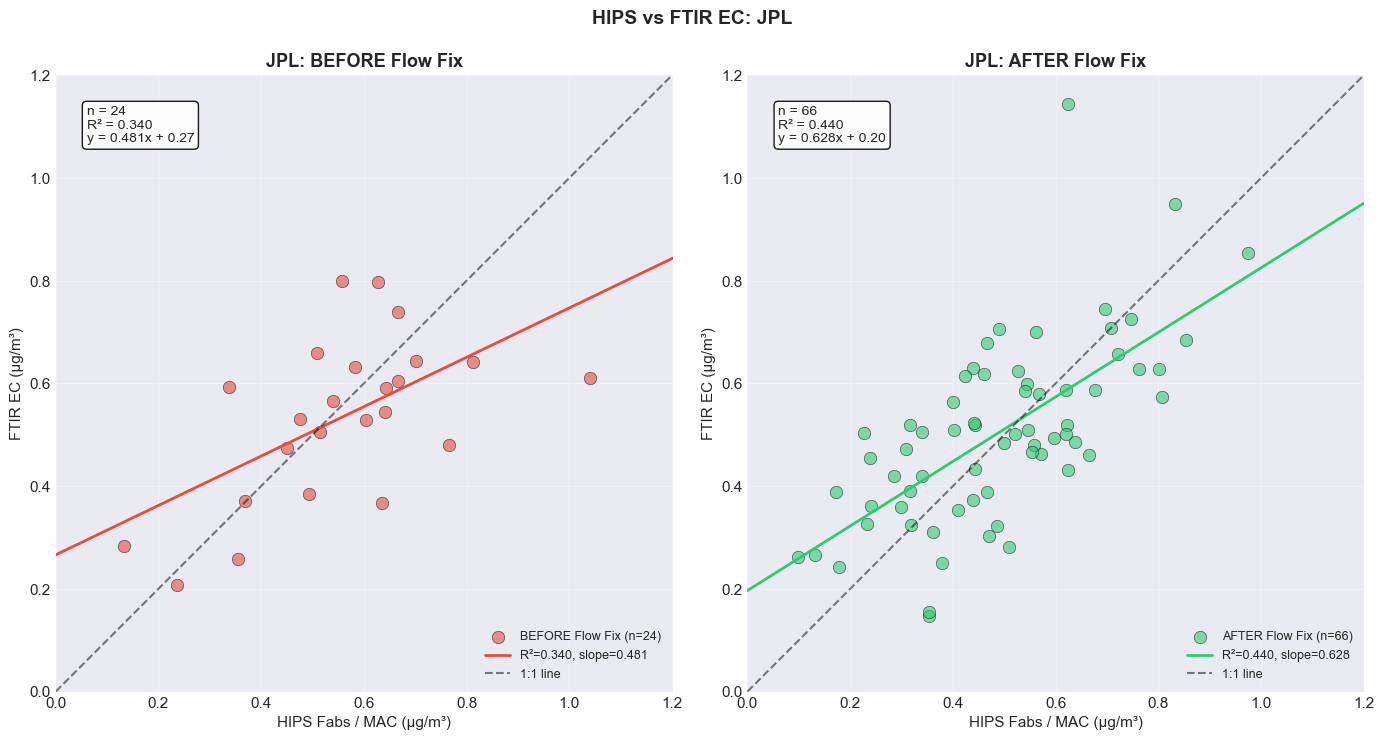


  R² change: 0.340 → 0.440 (Δ = +0.100)
  Slope change: 0.481 → 0.628 (Δ = +0.148)

Site: Beijing

Beijing sample counts: {'gap_period': 96, 'after_fix': 85, 'before_fix': 12}


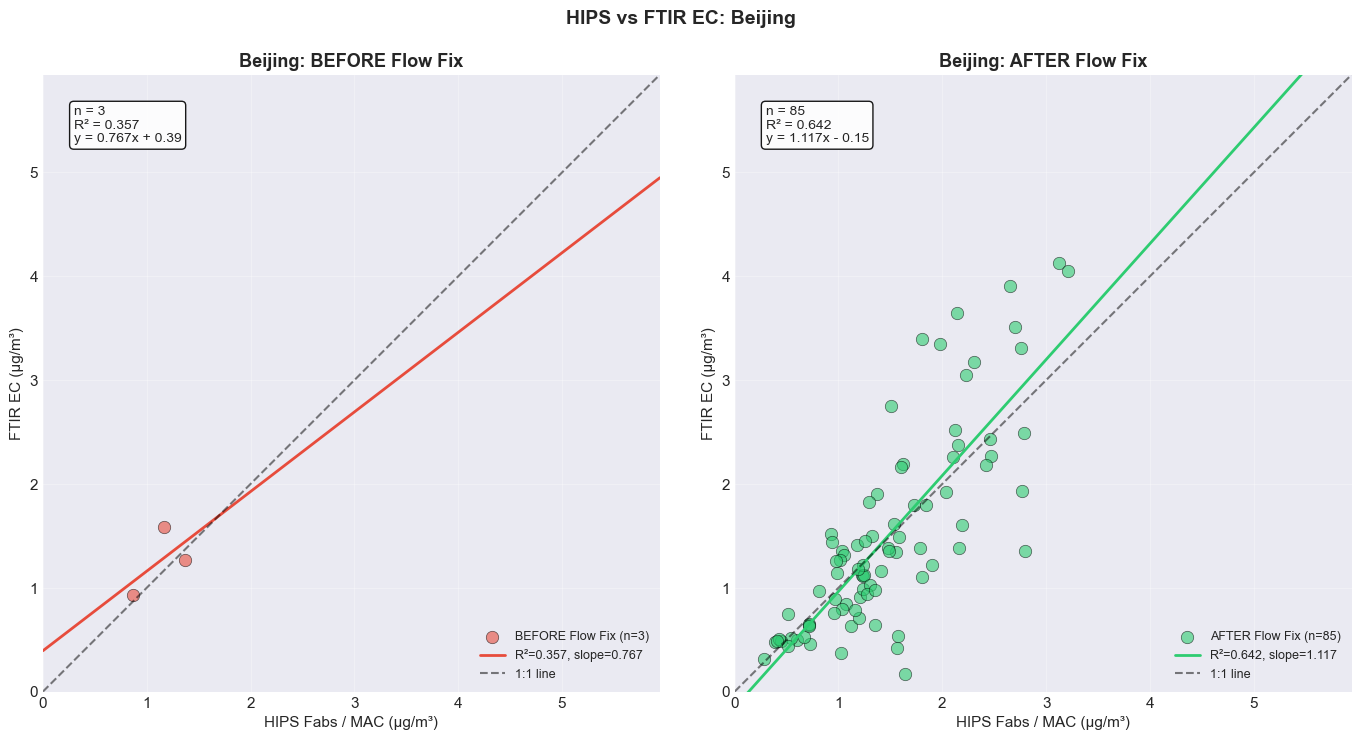


  R² change: 0.357 → 0.642 (Δ = +0.285)
  Slope change: 0.767 → 1.117 (Δ = +0.350)

Site: Delhi

Delhi sample counts: {'after_fix': 34, 'before_fix': 29}


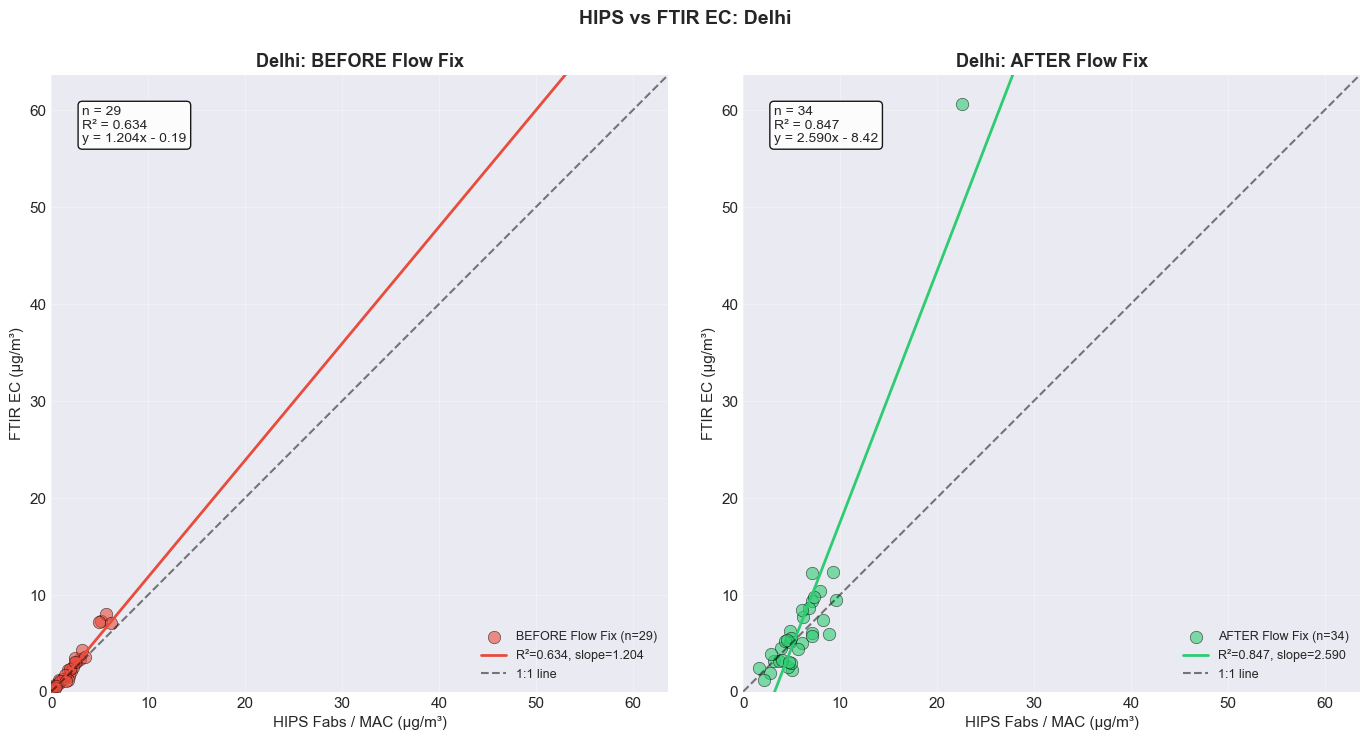


  R² change: 0.634 → 0.847 (Δ = +0.213)
  Slope change: 1.204 → 2.590 (Δ = +1.387)


In [198]:
# Analyze flow periods - HIPS vs FTIR EC (all sites)
print("\n" + "="*70)
print("FLOW PERIOD ANALYSIS: HIPS vs FTIR EC")
print("="*70)

flow_results_hips = {}

# Analyze all sites with data
for site_name in ['JPL', 'Beijing', 'Delhi']:
    if site_name in all_params_data:
        print(f"\n{'='*50}")
        print(f"Site: {site_name}")
        print(f"{'='*50}")
        
        results = analyze_flow_periods(
            site_name,
            all_params_data[site_name],
            x_col='hips_fabs',
            y_col='ftir_ec',
            xlabel='HIPS Fabs / MAC (µg/m³)',
            ylabel='FTIR EC (µg/m³)',
            title_prefix='HIPS vs FTIR EC'
        )
        if results:
            flow_results_hips[site_name] = results

In [199]:
# Summary table for flow period analysis (all sites)
print("\n" + "="*80)
print("SUMMARY: Before/After Flow Fix Comparison")
print("="*80)
print("\nNote: Only JPL has filter data in both before AND after flow fix periods")
print("      Beijing/Delhi filter sampling started after their flow fix dates")
print("      (Their 'before' periods show insufficient data)\n")

print("Aethalometer BC vs FTIR EC:")
print(f"{'Site':<15s} {'Period':<15s} {'n':<8s} {'R²':<10s} {'Slope':<10s}")
print("-" * 60)
for site_name in ['JPL', 'Beijing', 'Delhi']:
    if site_name in flow_results_aeth:
        results = flow_results_aeth[site_name]
        for period in ['before_fix', 'after_fix']:
            if period in results:
                r = results[period]
                label = 'Before' if period == 'before_fix' else 'After'
                n_val = r.get('n', 0)
                r2_val = r.get('r2', np.nan)
                slope_val = r.get('slope', np.nan)
                if np.isnan(r2_val):
                    print(f"{site_name:<15s} {label:<15s} {n_val:<8d} {'--':<10s} {'--':<10s}")
                else:
                    print(f"{site_name:<15s} {label:<15s} {n_val:<8d} {r2_val:<10.3f} {slope_val:<10.3f}")

print("\nHIPS vs FTIR EC:")
print(f"{'Site':<15s} {'Period':<15s} {'n':<8s} {'R²':<10s} {'Slope':<10s}")
print("-" * 60)
for site_name in ['JPL', 'Beijing', 'Delhi']:
    if site_name in flow_results_hips:
        results = flow_results_hips[site_name]
        for period in ['before_fix', 'after_fix']:
            if period in results:
                r = results[period]
                label = 'Before' if period == 'before_fix' else 'After'
                n_val = r.get('n', 0)
                r2_val = r.get('r2', np.nan)
                slope_val = r.get('slope', np.nan)
                if np.isnan(r2_val):
                    print(f"{site_name:<15s} {label:<15s} {n_val:<8d} {'--':<10s} {'--':<10s}")
                else:
                    print(f"{site_name:<15s} {label:<15s} {n_val:<8d} {r2_val:<10.3f} {slope_val:<10.3f}")


SUMMARY: Before/After Flow Fix Comparison

Note: Only JPL has filter data in both before AND after flow fix periods
      Beijing/Delhi filter sampling started after their flow fix dates
      (Their 'before' periods show insufficient data)

Aethalometer BC vs FTIR EC:
Site            Period          n        R²         Slope     
------------------------------------------------------------
JPL             Before          14       0.064      0.158     
JPL             After           54       0.129      0.240     
Beijing         After           72       0.227      0.606     
Delhi           After           25       0.608      0.942     

HIPS vs FTIR EC:
Site            Period          n        R²         Slope     
------------------------------------------------------------
JPL             Before          24       0.340      0.481     
JPL             After           66       0.440      0.628     
Beijing         Before          3        0.357      0.767     
Beijing         After 

---

# Task 4: Summary Tables

**Goal**: Create comprehensive summary tables including HIPS vs EC comparisons.

In [200]:
def calculate_site_stats(df, x_col, y_col):
    """Calculate regression statistics for a site."""
    valid_mask = df[x_col].notna() & df[y_col].notna()
    x = df.loc[valid_mask, x_col].values
    y = df.loc[valid_mask, y_col].values
    
    if len(x) < 3:
        return {'n': len(x), 'r2': np.nan, 'slope': np.nan, 'intercept': np.nan, 'rmse': np.nan}
    
    slope, intercept, r_value, _, _ = stats.linregress(x, y)
    rmse = np.sqrt(np.mean((y - (slope * x + intercept))**2))
    
    return {
        'n': len(x),
        'r2': r_value**2,
        'slope': slope,
        'intercept': intercept,
        'rmse': rmse
    }

In [201]:
# Build comprehensive summary table
print("\n" + "="*100)
print("COMPREHENSIVE SUMMARY TABLE")
print("="*100)

comparisons = [
    ('Aeth BC vs FTIR EC', 'ir_bcc', 'ftir_ec'),
    ('HIPS vs FTIR EC', 'hips_fabs', 'ftir_ec'),
    ('HIPS vs Aeth BC', 'hips_fabs', 'ir_bcc'),
]

summary_data = []

for site_name in SITES:
    if site_name not in all_params_data:
        continue
    
    df = all_params_data[site_name]
    
    for comp_name, x_col, y_col in comparisons:
        if x_col in df.columns and y_col in df.columns:
            stats_dict = calculate_site_stats(df, x_col, y_col)
            summary_data.append({
                'Site': site_name,
                'Comparison': comp_name,
                'n': stats_dict['n'],
                'R²': stats_dict['r2'],
                'Slope': stats_dict['slope'],
                'Intercept': stats_dict['intercept'],
                'RMSE': stats_dict['rmse']
            })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


COMPREHENSIVE SUMMARY TABLE
       Site         Comparison   n       R²    Slope  Intercept     RMSE
    Beijing Aeth BC vs FTIR EC  72 0.226811 0.606412   0.643156 0.857648
    Beijing    HIPS vs FTIR EC 161 0.541069 0.971241   0.038333 0.657875
    Beijing    HIPS vs Aeth BC  72 0.404249 0.688823   0.394597 0.591239
      Delhi Aeth BC vs FTIR EC  25 0.607861 0.942179  -2.335963 1.928691
      Delhi    HIPS vs FTIR EC  63 0.763893 1.998205  -3.485887 3.781608
      Delhi    HIPS vs Aeth BC  25 0.609168 1.174133   2.046575 1.593331
        JPL Aeth BC vs FTIR EC  68 0.150672 0.258422   0.353389 0.157462
        JPL    HIPS vs FTIR EC 130 0.521822 0.641416   0.194381 0.126633
        JPL    HIPS vs Aeth BC  68 0.326142 0.867354   0.218391 0.210673
Addis_Ababa Aeth BC vs FTIR EC 180 0.734196 0.645617  -0.010508 1.204981
Addis_Ababa    HIPS vs FTIR EC 189 0.784024 1.962825  -4.477362 1.070381
Addis_Ababa    HIPS vs Aeth BC 180 0.622753 2.348598  -3.566794 1.905215


In [202]:
# Pivot table format
print("\n" + "="*100)
print("SUMMARY BY COMPARISON TYPE")
print("="*100)

for comp_name, x_col, y_col in comparisons:
    print(f"\n{comp_name}:")
    print(f"{'Site':<15s} {'n':<8s} {'R²':<10s} {'Slope':<10s} {'Intercept':<12s} {'RMSE':<10s}")
    print("-" * 70)
    
    for site_name in SITES:
        if site_name not in all_params_data:
            continue
        
        df = all_params_data[site_name]
        if x_col in df.columns and y_col in df.columns:
            s = calculate_site_stats(df, x_col, y_col)
            print(f"{site_name:<15s} {s['n']:<8d} {s['r2']:<10.3f} {s['slope']:<10.3f} {s['intercept']:<12.2f} {s['rmse']:<10.2f}")


SUMMARY BY COMPARISON TYPE

Aeth BC vs FTIR EC:
Site            n        R²         Slope      Intercept    RMSE      
----------------------------------------------------------------------
Beijing         72       0.227      0.606      0.64         0.86      
Delhi           25       0.608      0.942      -2.34        1.93      
JPL             68       0.151      0.258      0.35         0.16      
Addis_Ababa     180      0.734      0.646      -0.01        1.20      

HIPS vs FTIR EC:
Site            n        R²         Slope      Intercept    RMSE      
----------------------------------------------------------------------
Beijing         161      0.541      0.971      0.04         0.66      
Delhi           63       0.764      1.998      -3.49        3.78      
JPL             130      0.522      0.641      0.19         0.13      
Addis_Ababa     189      0.784      1.963      -4.48        1.07      

HIPS vs Aeth BC:
Site            n        R²         Slope      Intercept    RMS

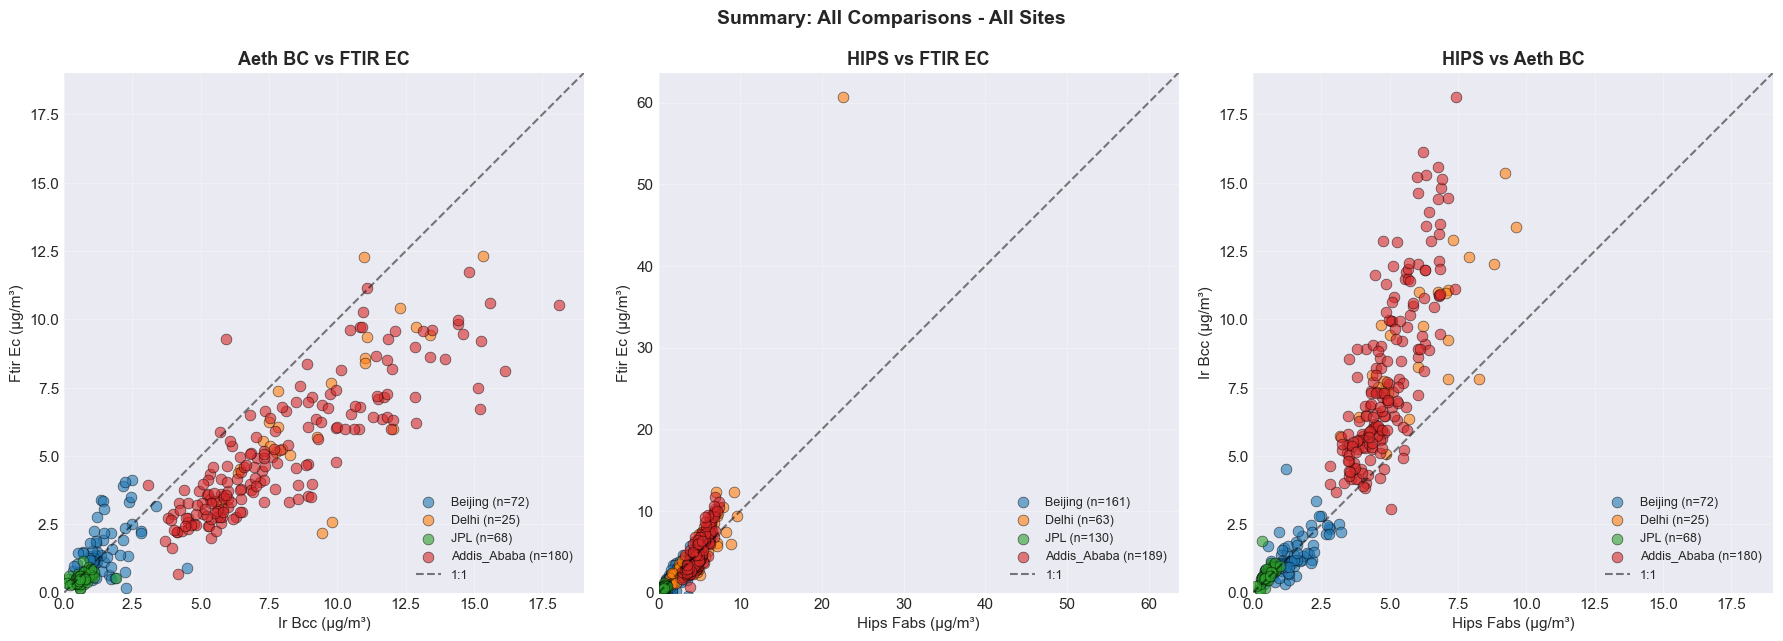

In [203]:
# Create visual summary plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (comp_name, x_col, y_col) in zip(axes, comparisons):
    # Calculate max value across all sites for consistent axes
    all_x, all_y = [], []
    for site_name, df in all_params_data.items():
        if x_col in df.columns and y_col in df.columns:
            valid = df[x_col].notna() & df[y_col].notna()
            all_x.extend(df.loc[valid, x_col].values)
            all_y.extend(df.loc[valid, y_col].values)
    
    if len(all_x) == 0:
        continue
    
    max_val = max(max(all_x), max(all_y)) * 1.05
    
    for site_name, df in all_params_data.items():
        if x_col in df.columns and y_col in df.columns:
            valid = df[x_col].notna() & df[y_col].notna()
            x = df.loc[valid, x_col].values
            y = df.loc[valid, y_col].values
            
            if len(x) >= 3:
                ax.scatter(x, y, c=SITE_COLORS.get(site_name), alpha=0.6, s=60,
                          edgecolors='black', linewidth=0.5, label=f"{site_name} (n={len(x)})")
    
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1')
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_xlabel(x_col.replace('_', ' ').title() + ' (µg/m³)', fontsize=11)
    ax.set_ylabel(y_col.replace('_', ' ').title() + ' (µg/m³)', fontsize=11)
    ax.set_title(comp_name, fontsize=13, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

plt.suptitle('Summary: All Comparisons - All Sites', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

# Key Findings Summary

In [204]:
print("\n" + "="*80)
print("KEY FINDINGS SUMMARY")
print("="*80)

print("\n1. IRON/EC RATIO THRESHOLDS:")
print("-" * 40)
# Find threshold with largest R² difference
best_threshold_aeth = None
best_delta_aeth = -999
for thresh, results in threshold_results_aeth.items():
    low_r2 = results.get('low', {}).get('r2', np.nan)
    high_r2 = results.get('high', {}).get('r2', np.nan)
    if not np.isnan(low_r2) and not np.isnan(high_r2):
        delta = low_r2 - high_r2
        if delta > best_delta_aeth:
            best_delta_aeth = delta
            best_threshold_aeth = thresh

if best_threshold_aeth:
    print(f"  Aethalometer vs FTIR EC: Best separation at Iron/EC = {best_threshold_aeth}")
    print(f"    ΔR² (low - high) = {best_delta_aeth:+.3f}")

best_threshold_hips = None
best_delta_hips = -999
for thresh, results in threshold_results_hips.items():
    low_r2 = results.get('low', {}).get('r2', np.nan)
    high_r2 = results.get('high', {}).get('r2', np.nan)
    if not np.isnan(low_r2) and not np.isnan(high_r2):
        delta = low_r2 - high_r2
        if delta > best_delta_hips:
            best_delta_hips = delta
            best_threshold_hips = thresh

if best_threshold_hips:
    print(f"  HIPS vs FTIR EC: Best separation at Iron/EC = {best_threshold_hips}")
    print(f"    ΔR² (low - high) = {best_delta_hips:+.3f}")

print("\n2. FLOW FIX IMPACT (JPL Only):")
print("-" * 40)
print("  Note: Only JPL has filter data in both before/after periods")
print("        Beijing/Delhi: filter sampling started after flow fix dates")
print()
if 'JPL' in flow_results_aeth:
    before = flow_results_aeth['JPL'].get('before_fix', {})
    after = flow_results_aeth['JPL'].get('after_fix', {})
    if before and after:
        b_r2 = before.get('r2', np.nan)
        a_r2 = after.get('r2', np.nan)
        if not np.isnan(b_r2) and not np.isnan(a_r2):
            print(f"  JPL (Aeth vs FTIR): R² {b_r2:.3f} → {a_r2:.3f} (Δ = {a_r2 - b_r2:+.3f})")
            print(f"  JPL (Aeth vs FTIR): Slope {before.get('slope', np.nan):.3f} → {after.get('slope', np.nan):.3f}")

print("\n3. HIPS vs AETHALOMETER COMPARISON:")
print("-" * 40)
for site_name in SITES:
    if site_name in all_params_data:
        df = all_params_data[site_name]
        aeth_stats = calculate_site_stats(df, 'ir_bcc', 'ftir_ec')
        hips_stats = calculate_site_stats(df, 'hips_fabs', 'ftir_ec')
        if not np.isnan(aeth_stats['r2']) and not np.isnan(hips_stats['r2']):
            print(f"  {site_name}: Aeth R²={aeth_stats['r2']:.3f}, HIPS R²={hips_stats['r2']:.3f} "
                  f"(HIPS {'better' if hips_stats['r2'] > aeth_stats['r2'] else 'worse'} by {abs(hips_stats['r2'] - aeth_stats['r2']):.3f})")


KEY FINDINGS SUMMARY

1. IRON/EC RATIO THRESHOLDS:
----------------------------------------
  Aethalometer vs FTIR EC: Best separation at Iron/EC = 200
    ΔR² (low - high) = +0.495
  HIPS vs FTIR EC: Best separation at Iron/EC = 300
    ΔR² (low - high) = +0.258

2. FLOW FIX IMPACT (JPL Only):
----------------------------------------
  Note: Only JPL has filter data in both before/after periods
        Beijing/Delhi: filter sampling started after flow fix dates

  JPL (Aeth vs FTIR): R² 0.064 → 0.129 (Δ = +0.065)
  JPL (Aeth vs FTIR): Slope 0.158 → 0.240

3. HIPS vs AETHALOMETER COMPARISON:
----------------------------------------
  Beijing: Aeth R²=0.227, HIPS R²=0.541 (HIPS better by 0.314)
  Delhi: Aeth R²=0.608, HIPS R²=0.764 (HIPS better by 0.156)
  JPL: Aeth R²=0.151, HIPS R²=0.522 (HIPS better by 0.371)
  Addis_Ababa: Aeth R²=0.734, HIPS R²=0.784 (HIPS better by 0.050)


---

## Next Steps / Open Questions

1. **Iron threshold recommendation**: Based on the analysis above, what Iron/EC ratio cutoff should be used for flagging potentially affected samples?

2. **Flow fix verification**: Do the before/after improvements in Beijing and JPL align with expectations from the instrument maintenance logs?

3. **HIPS vs Aethalometer**: Is the improved correlation with HIPS due to (a) both measuring absorption, or (b) timing alignment with filter samples?

4. **Site-specific considerations**: Should different Iron/EC thresholds be used for different sites based on local dust composition?